# Africa Credit Challenge

The goals of this `starter notebook` are:

1. How to load data into a `Pandas` dataframe

2. How to `train` a basic machine learning model

3. How to `evaluate` the model

4. How to `save` your __submission__ following the required format.

<font color="red"><b>Note: This is just a starter notebook. It is by no means an ideal solution.</b></font>

In [102]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

## Load and Inspect the data

In [64]:
# Loading the train dataset
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
# Display the first few rows of the datasets and their shape
display("Train", train.head(), train.shape, "Test", test.head(), test.shape)

'Train'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0


(68654, 16)

'Test'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,7,Repeat Loan,575.7,0.300000,597.0
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,7,Repeat Loan,0.0,0.000000,0.0
2,ID_257026243764267278,257026,Kenya,243764,267278,Type_1,8254.0,8304.0,2022-08-24,2022-08-31,7,Repeat Loan,207.0,0.025079,208.0
3,ID_264617299409267278,264617,Kenya,299409,267278,Type_1,3379.0,3379.0,2022-11-15,2022-11-22,7,Repeat Loan,1013.7,0.300000,1014.0
4,ID_247613296713267278,247613,Kenya,296713,267278,Type_1,120.0,120.0,2022-11-10,2022-11-17,7,Repeat Loan,36.0,0.300000,36.0


(18594, 15)

In [3]:
# Check column types & missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           68654 non-null  object 
 1   customer_id                  68654 non-null  int64  
 2   country_id                   68654 non-null  object 
 3   tbl_loan_id                  68654 non-null  int64  
 4   lender_id                    68654 non-null  int64  
 5   loan_type                    68654 non-null  object 
 6   Total_Amount                 68654 non-null  float64
 7   Total_Amount_to_Repay        68654 non-null  float64
 8   disbursement_date            68654 non-null  object 
 9   due_date                     68654 non-null  object 
 10  duration                     68654 non-null  int64  
 11  New_versus_Repeat            68654 non-null  object 
 12  Amount_Funded_By_Lender      68654 non-null  float64
 13  Lender_portion_F

In [4]:
# Are there missing values in the train dataset ?
print(f"There are {train.isna().sum().sum()} missing values in the data.")

There are 0 missing values in the data.


### EDA

In [5]:
def plot_continuous(df, column, transform=None):
    """
    Plots visualizations for a continuous variable, showing the distribution and boxplot for both
    the original and transformed versions of the data.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The column name of the continuous variable to plot.
        transform (str, optional): Transformation to apply to the data before plotting.
                                  Accepted values are 'log' or 'sqrt'. Default is None, which means no transformation.

    This function generates:
        - A histogram with a kernel density estimate (KDE) for the original data.
        - A boxplot for the original data.
        - If a transformation is specified ('log' or 'sqrt'):
            - A histogram with a KDE for the transformed data.
            - A boxplot for the transformed data.
    """
    # Create subplots for visualizations
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))

    # Original data plots
    sns.histplot(df[column], kde=True, ax=axs[0, 0])
    axs[0, 0].set_title(f'Distribution of {column}')
    axs[0, 0].set_xlabel(column)

    sns.boxplot(y=df[column], ax=axs[1, 0])
    axs[1, 0].set_title(f'Box Plot of {column}')
    axs[1, 0].set_ylabel(column)

    # Transformations (log or square root)
    if transform == 'log':
        transformed_data = np.log1p(df[column])  # log1p handles log(0) gracefully
        transform_label = 'Log'
    elif transform == 'sqrt':
        transformed_data = np.sqrt(df[column])  # Square root transformation
        transform_label = 'Square Root'
    else:
        transformed_data = None  # No transformation if not specified

    # If transformed data exists, generate corresponding plots
    if transformed_data is not None:
        sns.histplot(transformed_data, kde=True, ax=axs[0, 1])
        axs[0, 1].set_title(f'{transform_label} Distribution of {column}')
        axs[0, 1].set_xlabel(f'{transform_label}({column})')

        sns.boxplot(y=transformed_data, ax=axs[1, 1])
        axs[1, 1].set_title(f'{transform_label} Box Plot of {column}')
        axs[1, 1].set_ylabel(f'{transform_label}({column})')
    else:
        # If no transformation, remove the second set of axes
        for ax in [axs[0, 1], axs[1, 1]]:
            ax.remove()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


def plot_categorical(df, column):
    """
    Plots visualizations for a categorical variable, including a bar plot and a pie chart.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The column name of the categorical variable to plot.

    This function generates:
        - A bar plot showing the counts of each category in the specified column.
        - A pie chart showing the relative proportions of each category.
    """
    # Create subplots for visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Bar plot showing counts of each category
    value_counts = df[column].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax1)
    ax1.set_title(f'Bar Plot of {column}')
    ax1.set_xlabel(column)
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    # Pie chart showing percentage distribution of each category
    ax2.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
    ax2.set_title(f'Pie Chart of {column}')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


#### Categorical exploration

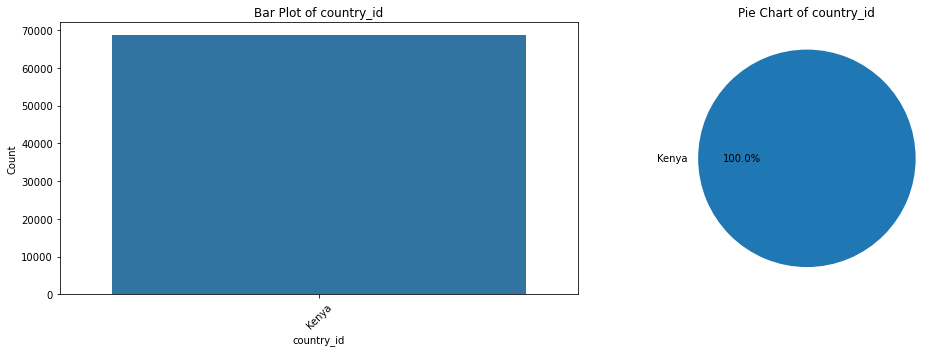

In [6]:
plot_categorical(train, 'country_id')

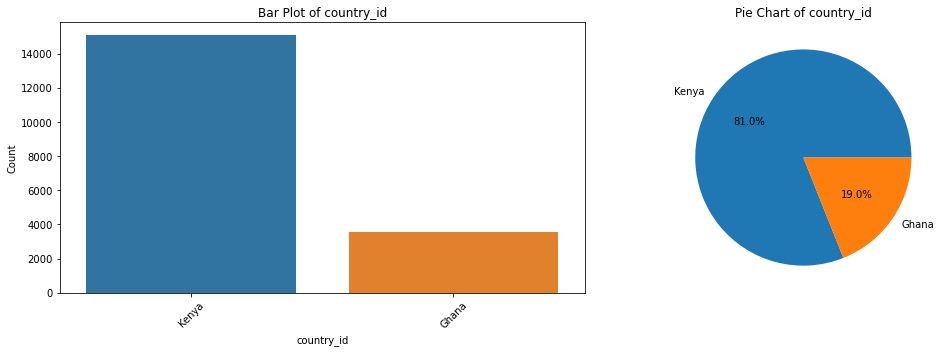

In [7]:
plot_categorical(test, 'country_id')

##### This shows that test has a new country, ghana so one of the goals is to build a solution that can generalize well in new regions

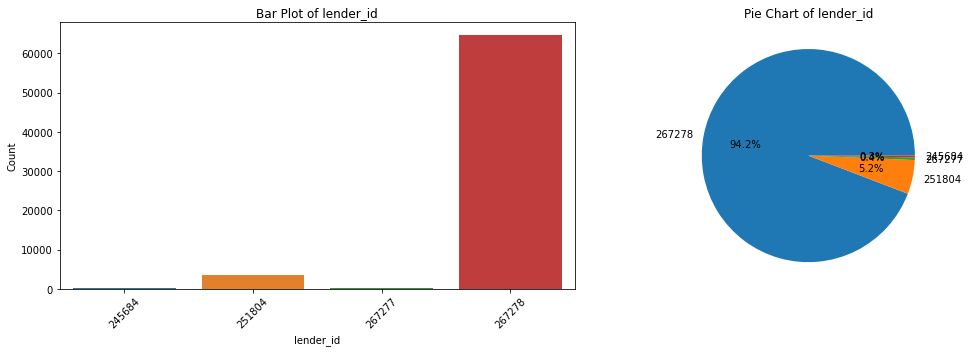

In [8]:
plot_categorical(train, 'lender_id')

##### You can exploree more of the categorical columns as well

#### TARGET EXPLORATION


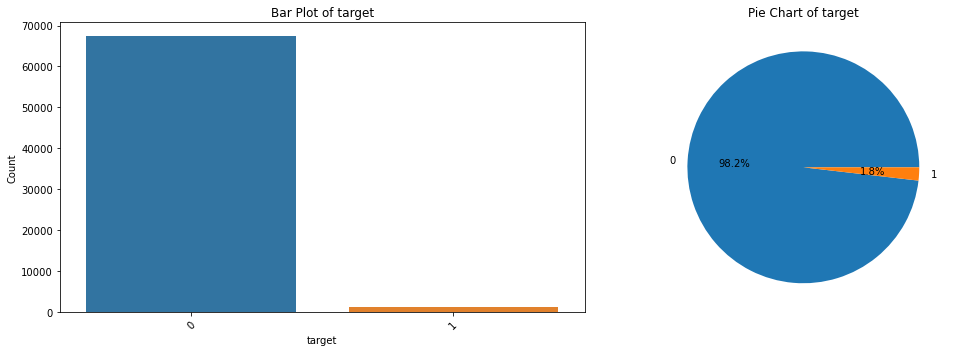

In [9]:
plot_categorical(train, 'target')

##### You can see the dataset is highly imbalanced , and this is expected in loan default scenarios, So find  ways to deal with the  imbalance

### CONTINUOUS COLUMN EXPLORATION

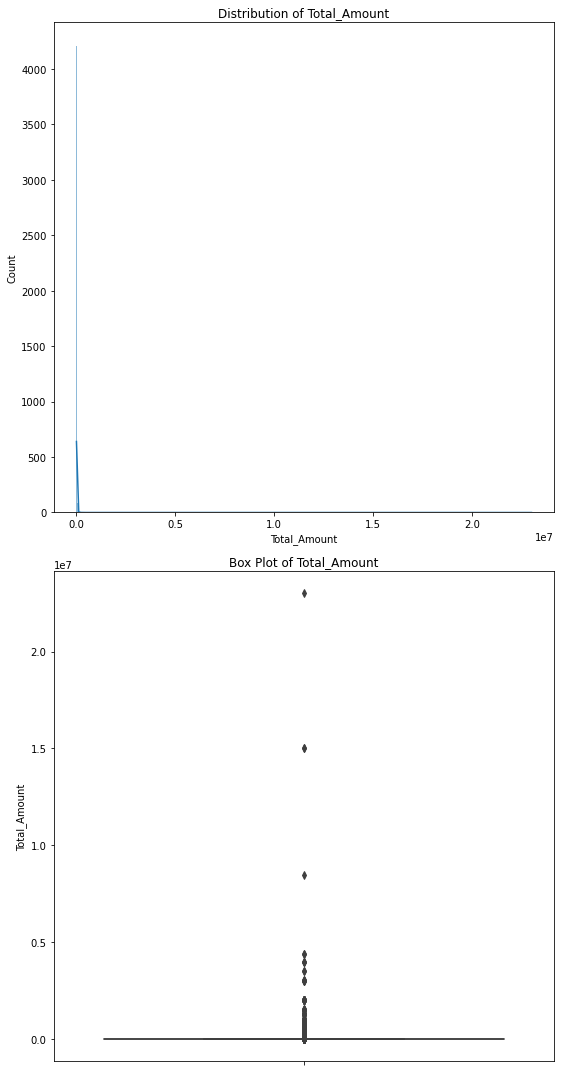

In [10]:
plot_continuous(train, 'Total_Amount')

Are those outliers?
##### You can explore more of the given numerical columns as well

### Feature Engineering
* So here we are going to concatenate both the train and test so that we can do the processing once instead of repeating for each

In [53]:
data = pd.concat([train, test]).reset_index(drop=True)

# Convert the datetime columns appropriately
date_cols = ['disbursement_date', 'due_date']
for col in date_cols:
    data[col] = pd.to_datetime(data[col])
    # Extract month, day, and year from the date columns
    data[col+'_month'] = data[col].dt.month
    data[col+'_day'] = data[col].dt.day
    data[col+'_year'] = data[col].dt.year

# Select all categorical columns from the dataset and label encode them or one hot encode
cat_cols = data.select_dtypes(include='object').columns
num_cols = [col for col in data.select_dtypes(include='number').columns if col not in ['target']]
print(f"The categorical columns are: {cat_cols}.")
print("-"* 100)
print(f"The numerical columns are: {num_cols}")
print("-"* 100)
# we are going to one  hot encode the loan type
data = pd.get_dummies(data, columns=['loan_type'], prefix='loan_type', drop_first=False)
# Convert all the columns with prefix loan_type_ to 0/1 instead of False/True
loan_type_cols = [col for col in data.columns if col.startswith('loan_type_')]
data[loan_type_cols] = data[loan_type_cols].astype(int)

# Label-encoding for the other remaining categorical columns
le = LabelEncoder()
for col in [col for col in cat_cols if col not in ['loan_type', 'ID']]:
    data[col] = le.fit_transform(data[col])


# deal with numerical columns: we saw loan amount is  highly right skewed for this we can log transform it
data['Total_Amount'] = np.log1p(data['Total_Amount']) # study other numerical columns and see if they are skewed as well

# Splitting the data back into train and test
train_df = data[data['ID'].isin(train['ID'].unique())]

test_df = data[data['ID'].isin(test['ID'].unique())]

# we are also going to drop the country id as we saw we have only one country in train
features_for_modelling = [col for col in train_df.columns if col not in date_cols + ['ID', 'target', 'country_id']]

# Check if the new datasets have the same rows as train and test datasets
print(f"The shape of train_df is: {train_df.shape}")
print(f"The shape of test_df is: {test_df.shape}")
print(f"The shape of train is: {train.shape}")
print(f"The shape of test is: {test.shape}")
print(f"The features for modelling are:\n{features_for_modelling}")


The categorical columns are: Index(['ID', 'country_id', 'loan_type', 'New_versus_Repeat'], dtype='object').
----------------------------------------------------------------------------------------------------
The numerical columns are: ['customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount', 'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'disbursement_date_month', 'disbursement_date_day', 'disbursement_date_year', 'due_date_month', 'due_date_day', 'due_date_year']
----------------------------------------------------------------------------------------------------
The shape of train_df is: (68654, 45)
The shape of test_df is: (18594, 45)
The shape of train is: (68654, 16)
The shape of test is: (18594, 15)
The features for modelling are:
['customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount', 'Total_Amount_to_Repay', 'duration', 'New_versus_Repeat', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'Lender_

### CROSS VALIDATION
* Here we are going to use a simple train test split but due to the imbalance try other robust methods like StratifiedKFold


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_df[features_for_modelling], train['target'], stratify=train['target'], shuffle=True, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(51490, 40) (17164, 40) (51490,) (17164,)


## Initialisation & Model Training

F1 Score: 0.2616
ROC AUC Score: 0.9285

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96     16849
           1       0.16      0.80      0.26       315

    accuracy                           0.92     17164
   macro avg       0.58      0.86      0.61     17164
weighted avg       0.98      0.92      0.94     17164



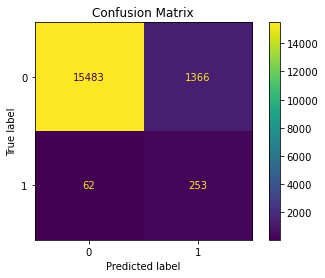

In [21]:

# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Logistic Regression Classifier
clf = LogisticRegression(
    random_state=42,
    class_weight="balanced",  # Handle class imbalance
)
clf.fit(X_train_scaled, y_train)

# Predictions
y_pred = clf.predict(X_valid_scaled)
y_pred_proba = clf.predict_proba(X_valid_scaled)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Confusion Matrix
# Confusion Matrix Visualization
ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=clf.classes_,
#     cmap=plt.cm.Blues
).plot()
plt.title("Confusion Matrix")
plt.show()


### FEATURE IMPORTANCE

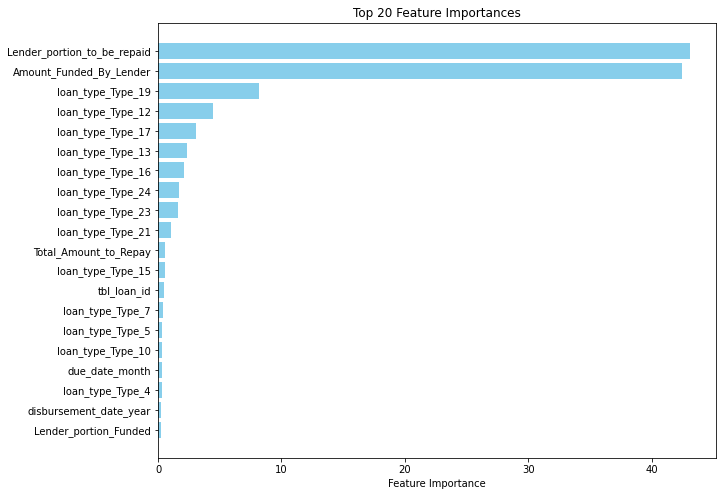

In [22]:
# Feature Importance

# Get the absolute values of the coefficients
feature_importances = np.abs(clf.coef_).flatten()

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': features_for_modelling,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.show()

## Model Prediction & Inference

In [26]:
importance_df['Feature'][:12]

9     Lender_portion_to_be_repaid
7         Amount_Funded_By_Lender
26              loan_type_Type_19
19              loan_type_Type_12
24              loan_type_Type_17
20              loan_type_Type_13
23              loan_type_Type_16
32              loan_type_Type_24
31              loan_type_Type_23
29              loan_type_Type_21
4           Total_Amount_to_Repay
22              loan_type_Type_15
Name: Feature, dtype: object

In [40]:
features_for_modelling = ['Lender_portion_to_be_repaid',
                          'Amount_Funded_By_Lender',
                          'loan_type_Type_19',
                          'loan_type_Type_12',
                          'loan_type_Type_17',
                          'loan_type_Type_13',
                          'loan_type_Type_16',
                          'loan_type_Type_24',
                          'loan_type_Type_23',
                          'loan_type_Type_21',
                          'Total_Amount_to_Repay',
                          'loan_type_Type_15']

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_df[features_for_modelling], train['target'], stratify=train['target'], shuffle=True, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(51490, 12) (17164, 12) (51490,) (17164,)


F1 Score: 0.5755
ROC AUC Score: 0.9400

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     16849
           1       0.53      0.63      0.58       315

    accuracy                           0.98     17164
   macro avg       0.76      0.81      0.78     17164
weighted avg       0.98      0.98      0.98     17164



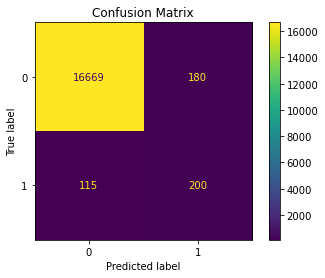

In [29]:

# # Standard Scaling
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_valid_scaled = scaler.transform(X_valid)

# # Logistic Regression Classifier
# clf = LogisticRegression(
#     random_state=seed,
#     class_weight="balanced",  # Handle class imbalance
# )
# clf.fit(X_train_scaled, y_train)

# # Predictions
# y_pred = clf.predict(X_valid_scaled)
# y_pred_proba = clf.predict_proba(X_valid_scaled)[:, 1]

# # Evaluation Metrics
# f1 = f1_score(y_valid, y_pred)
# roc_auc = roc_auc_score(y_valid, y_pred_proba)

# print(f"F1 Score: {f1:.4f}")
# print(f"ROC AUC Score: {roc_auc:.4f}")
# print("\nClassification Report:\n", classification_report(y_valid, y_pred))

# # Compute the confusion matrix
# cm = confusion_matrix(y_valid, y_pred)

# # Confusion Matrix
# # Confusion Matrix Visualization
# ConfusionMatrixDisplay(
#     confusion_matrix=cm,
#     display_labels=clf.classes_,
# #     cmap=plt.cm.Blues
# ).plot()
# plt.title("Confusion Matrix")
# plt.show()


F1 Score: 0.6133
ROC AUC Score: 0.9583

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     16849
           1       0.54      0.72      0.61       315

    accuracy                           0.98     17164
   macro avg       0.77      0.85      0.80     17164
weighted avg       0.99      0.98      0.98     17164



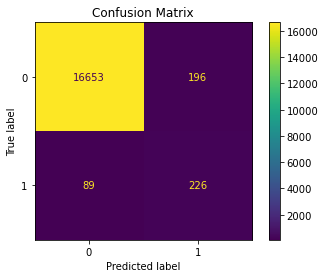

In [42]:
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Normalize the data
normalizer = Normalizer()
X_train_normalized = normalizer.fit_transform(X_train)
X_valid_normalized = normalizer.transform(X_valid)

# Logistic Regression Classifier
clf = LogisticRegression(
    random_state=SEED,
    class_weight="balanced"  # Handle class imbalance
)
clf.fit(X_train_normalized, y_train)

# Predictions
y_pred = clf.predict(X_valid_normalized)
y_pred_proba = clf.predict_proba(X_valid_normalized)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Confusion Matrix Visualization
ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=clf.classes_
).plot()
plt.title("Confusion Matrix")
plt.show()


#### Using K Folds Crossvalidation to tune hyperparameters

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 21.7min finished


Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation F1 Score: 0.6314576157138779
F1 Score: 0.6128
ROC AUC Score: 0.9315

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     16849
           1       0.59      0.64      0.61       315

    accuracy                           0.99     17164
   macro avg       0.79      0.81      0.80     17164
weighted avg       0.99      0.99      0.99     17164



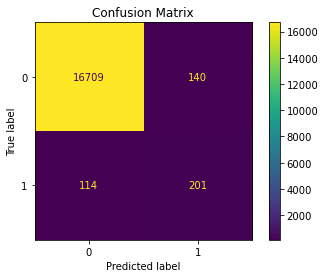

In [45]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.metrics import (
    make_scorer,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Normalize the data
normalizer = Normalizer()
X_train_normalized = normalizer.fit_transform(X_train)
X_valid_normalized = normalizer.transform(X_valid)

# Define parameter grid for Logistic Regression
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    "penalty": ["l1", "l2", "elasticnet"],  # Regularization penalties
    "solver": ["liblinear", "saga"],  # Solvers compatible with l1 or elasticnet
    "class_weight": ["balanced", None],  # Handle class imbalance
}

# Custom scorer combining F1 and ROC AUC
scorer = make_scorer(f1_score, average="binary")

# Stratified K-Folds for balanced class splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Perform Grid Search with Cross Validation
clf = LogisticRegression(random_state=SEED, max_iter=1000)
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    verbose=1,
    n_jobs=-1,  # Utilize all processors
)

# Fit Grid Search on training data
grid_search.fit(X_train_normalized, y_train)

# Best parameters and score from cross-validation
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation F1 Score:", grid_search.best_score_)

# Train the best model on the full training set
best_clf = grid_search.best_estimator_

# Predictions on validation set
y_pred = best_clf.predict(X_valid_normalized)
y_pred_proba = best_clf.predict_proba(X_valid_normalized)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_valid, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_).plot()
plt.title("Confusion Matrix")
plt.show()


In [55]:
# Make predictions on the test dataset
test_predictions = best_clf.predict(test_df[features_for_modelling])
test_predictions_proba = best_clf.predict_proba(test_df[features_for_modelling])[:, 1]

# Save the predictions to a CSV file

test_df['target'] = test_predictions
sub =  test_df[['ID', 'target']]
sub.head()


In [47]:
sub.to_csv('baseline_submission.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

# Load data
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

combined_df = pd.concat([train_df, test_df]).reset_index(drop=True)

### Step 1: Feature Engineering
# 1. Date Features
combined_df['disbursement_date'] = pd.to_datetime(combined_df['disbursement_date'])
combined_df['due_date'] = pd.to_datetime(combined_df['due_date'])
combined_df['loan_term_days'] = (combined_df['due_date'] - combined_df['disbursement_date']).dt.days

# 2. Financial Ratios
combined_df['repayment_ratio'] = combined_df['Total_Amount_to_Repay'] / combined_df['Total_Amount']
combined_df['lender_funded_ratio'] = combined_df['Amount_Funded_By_Lender'] / combined_df['Total_Amount']

# 3. One-hot encode categorical features
categorical_cols = ['country_id', 'loan_type', 'New_versus_Repeat']
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

# 4. Encode object IDs
id_cols = ['customer_id', 'tbl_loan_id', 'lender_id']
label_encoders = {col: LabelEncoder() for col in id_cols}
for col in id_cols:
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Split back into train and test
train = combined_df[combined_df['ID'].isin(train_df['ID'].unique())]
test = combined_df[combined_df['ID'].isin(test_df['ID'].unique())]

### Step 2: Define Features and Target
features = [col for col in train.columns if col not in ['ID', 'target', 'disbursement_date', 'due_date']]
X_test = test[features]

# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    train[features],
    train_df['target'],
    stratify=train_df['target'],
    shuffle=True,
    random_state=SEED
)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

### Step 3: Oversample Minority Class
smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

### Step 4: Feature Selection
selector = SelectKBest(score_func=mutual_info_classif, k=20)  # Select top 20 features
X_train_selected = selector.fit_transform(X_train_res, y_train_res)
X_valid_selected = selector.transform(X_valid)
X_test_selected = selector.transform(X_test)

selected_features = [features[i] for i in selector.get_support(indices=True)]
print("Selected Features:", selected_features)

### Step 5: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_valid_scaled = scaler.transform(X_valid_selected)
X_test_scaled = scaler.transform(X_test_selected)

### Step 6: Hyperparameter Tuning
logreg = LogisticRegression(random_state=SEED, max_iter=1000, class_weight='balanced')
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'],  # Regularization types
    'solver': ['saga'],  # Solver compatible with all penalties
    'l1_ratio': [0.1, 0.5, 0.9]  # ElasticNet mixing parameter
}

grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_res)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

### Step 7: Model Evaluation
y_valid_pred = best_model.predict(X_valid_scaled)
y_valid_proba = best_model.predict_proba(X_valid_scaled)[:, 1]

f1 = f1_score(y_valid, y_valid_pred)
roc_auc = roc_auc_score(y_valid, y_valid_proba)

print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

cm = confusion_matrix(y_valid, y_valid_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

### Step 8: Predict on Test Data
y_test_pred = best_model.predict(X_test_scaled)
test_df['target'] = y_test_pred

# Prepare submission file
submission = test_df[['ID', 'target']]
submission.to_csv("submission_file_logreg.csv", index=False)
print("Submission file created: submission_file_logreg.csv")


(51490, 37) (17164, 37) (51490,) (17164,)
Selected Features: ['customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount', 'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'loan_term_days', 'repayment_ratio', 'lender_funded_ratio', 'country_id_Kenya', 'loan_type_Type_10', 'loan_type_Type_11', 'loan_type_Type_14', 'loan_type_Type_4', 'loan_type_Type_7', 'loan_type_Type_9', 'New_versus_Repeat_Repeat Loan']

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     16849
           1       0.33      0.93      0.49       315

    accuracy                           0.96     17164
   macro avg       0.67      0.95      0.74     17164
weighted avg       0.99      0.96      0.97     17164

F1 Score: 0.4887
ROC AUC Score: 0.9853


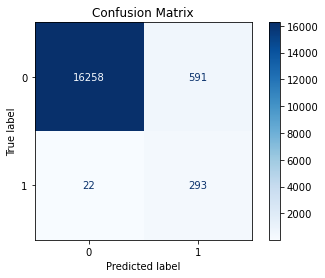

Submission file created: submission_file_logreg.csv


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

# Load data
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

combined_df = pd.concat([train_df, test_df]).reset_index(drop=True)

### Step 1: Feature Engineering
# 1. Date Features
combined_df['disbursement_date'] = pd.to_datetime(combined_df['disbursement_date'])
combined_df['due_date'] = pd.to_datetime(combined_df['due_date'])
combined_df['loan_term_days'] = (combined_df['due_date'] - combined_df['disbursement_date']).dt.days

# 2. Financial Ratios
combined_df['repayment_ratio'] = combined_df['Total_Amount_to_Repay'] / combined_df['Total_Amount']
combined_df['lender_funded_ratio'] = combined_df['Amount_Funded_By_Lender'] / combined_df['Total_Amount']

# 3. One-hot encode categorical features
categorical_cols = ['country_id', 'loan_type', 'New_versus_Repeat']
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

# 4. Encode object IDs
id_cols = ['customer_id', 'tbl_loan_id', 'lender_id']
label_encoders = {col: LabelEncoder() for col in id_cols}
for col in id_cols:
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Split back into train and test
train = combined_df[combined_df['ID'].isin(train_df['ID'].unique())]
test = combined_df[combined_df['ID'].isin(test_df['ID'].unique())]

### Step 2: Define Features and Target
features = [col for col in train.columns if col not in ['ID', 'target', 'disbursement_date', 'due_date']]
X_test = test[features]

# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    train[features],
    train_df['target'],
    stratify=train_df['target'],
    shuffle=True,
    random_state=SEED
)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

### Step 3: Oversample Minority Class
smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

### Step 4: Feature Selection
selector = SelectKBest(score_func=mutual_info_classif, k=20)  # Select top 20 features
X_train_selected = selector.fit_transform(X_train_res, y_train_res)
X_valid_selected = selector.transform(X_valid)
X_test_selected = selector.transform(X_test)

selected_features = [features[i] for i in selector.get_support(indices=True)]
print("Selected Features:", selected_features)

### Step 5: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_valid_scaled = scaler.transform(X_valid_selected)
X_test_scaled = scaler.transform(X_test_selected)

### Step 6: Train Logistic Regression with Best Parameters
logreg = LogisticRegression(
    C=1,
    penalty='l2',
    solver='liblinear',
    class_weight='balanced',
    random_state=SEED,
    max_iter=500
)
logreg.fit(X_train_scaled, y_train_res)

### Step 7: Model Evaluation
y_valid_pred = logreg.predict(X_valid_scaled)
y_valid_proba = logreg.predict_proba(X_valid_scaled)[:, 1]

f1 = f1_score(y_valid, y_valid_pred)
roc_auc = roc_auc_score(y_valid, y_valid_proba)

print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

cm = confusion_matrix(y_valid, y_valid_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

### Step 8: Predict on Test Data
y_test_pred = logreg.predict(X_test_scaled)
test_df['target'] = y_test_pred

# Prepare submission file
submission = test_df[['ID', 'target']]
submission.to_csv("submission_file_logreg.csv", index=False)
print("Submission file created: submission_file_logreg.csv")


(51490, 37) (17164, 37) (51490,) (17164,)
Selected Features: ['customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount', 'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'loan_term_days', 'repayment_ratio', 'lender_funded_ratio', 'country_id_Kenya', 'loan_type_Type_10', 'loan_type_Type_11', 'loan_type_Type_12', 'loan_type_Type_13', 'loan_type_Type_14', 'loan_type_Type_15', 'loan_type_Type_16', 'loan_type_Type_17', 'loan_type_Type_18', 'loan_type_Type_19', 'loan_type_Type_2', 'loan_type_Type_20', 'loan_type_Type_21', 'loan_type_Type_22', 'loan_type_Type_23', 'loan_type_Type_24', 'loan_type_Type_3', 'loan_type_Type_4', 'loan_type_Type_5', 'loan_type_Type_6', 'loan_type_Type_7', 'loan_type_Type_8', 'loan_type_Type_9', 'New_versus_Repeat_Repeat Loan']

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     16849
           1       0.34      0.92    

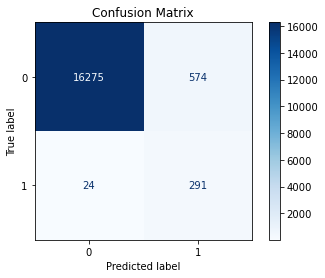

Submission file created: submission_file_ensemble.csv


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

# Load data
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

combined_df = pd.concat([train_df, test_df]).reset_index(drop=True)

### Step 1: Feature Engineering
# 1. Date Features
combined_df['disbursement_date'] = pd.to_datetime(combined_df['disbursement_date'])
combined_df['due_date'] = pd.to_datetime(combined_df['due_date'])
combined_df['loan_term_days'] = (combined_df['due_date'] - combined_df['disbursement_date']).dt.days

# 2. Financial Ratios
combined_df['repayment_ratio'] = combined_df['Total_Amount_to_Repay'] / combined_df['Total_Amount']
combined_df['lender_funded_ratio'] = combined_df['Amount_Funded_By_Lender'] / combined_df['Total_Amount']

# 3. One-hot encode categorical features
categorical_cols = ['country_id', 'loan_type', 'New_versus_Repeat']
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

# 4. Encode object IDs
id_cols = ['customer_id', 'tbl_loan_id', 'lender_id']
label_encoders = {col: LabelEncoder() for col in id_cols}
for col in id_cols:
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Split back into train and test
train = combined_df[combined_df['ID'].isin(train_df['ID'].unique())]
test = combined_df[combined_df['ID'].isin(test_df['ID'].unique())]

### Step 2: Define Features and Target
features = [col for col in train.columns if col not in ['ID', 'target', 'disbursement_date', 'due_date']]
X_test = test[features]

# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    train[features],
    train_df['target'],
    stratify=train_df['target'],
    shuffle=True,
    random_state=SEED
)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

### Step 3: Oversample Minority Class
smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

### Step 4: Feature Selection
selector = SelectKBest(score_func=mutual_info_classif, k=37)  # Select top 20 features
X_train_selected = selector.fit_transform(X_train_res, y_train_res)
X_valid_selected = selector.transform(X_valid)
X_test_selected = selector.transform(X_test)

selected_features = [features[i] for i in selector.get_support(indices=True)]
print("Selected Features:", selected_features)

### Step 5: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_valid_scaled = scaler.transform(X_valid_selected)
X_test_scaled = scaler.transform(X_test_selected)

### Step 6: Train Logistic Regression for Minority Class
logreg = LogisticRegression(
    C=0.1,
    penalty='l2',
    solver='liblinear',
    class_weight='balanced',
    random_state=SEED,
    max_iter=500
)
logreg.fit(X_train_scaled, y_train_res)

# Predict probabilities for minority class
logreg_probs = logreg.predict(X_valid_scaled)#[:, 1]

### Step 7: Train XGBoost for Majority Class
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    max_depth=10,
    eta=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=SEED
)
xgb_model.fit(X_train_res, y_train_res)

# Predict probabilities for majority class
xgb_probs = xgb_model.predict(X_valid_selected)

### Step 8: Combine Probabilities
w_logreg = 0.6  # Weight for Logistic Regression
w_xgb = 0.4     # Weight for XGBoost
combined_probs = w_logreg * logreg_probs + w_xgb * xgb_probs

# Final Predictions
final_preds = np.round((combined_probs > 0.5)) #.astype(int)

### Step 9: Model Evaluation
print("\nClassification Report:\n", classification_report(y_valid, final_preds))
f1 = f1_score(y_valid, final_preds)
roc_auc = roc_auc_score(y_valid, combined_probs)
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

cm = confusion_matrix(y_valid, final_preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

### Step 10: Predict on Test Data
logreg_test_probs = logreg.predict(X_test_scaled)
xgb_test_probs = xgb_model.predict(X_test_selected)
test_combined_probs = w_logreg * logreg_test_probs + w_xgb * xgb_test_probs
test_preds = np.round((test_combined_probs > 0.5))#.astype(int)

test_df['target'] = test_preds

# Prepare submission file
submission = test_df[['ID', 'target']]
submission.to_csv("submission_file_ensemble.csv", index=False)
print("Submission file created: submission_file_ensemble.csv")


(51490, 37) (17164, 37) (51490,) (17164,)
Selected Features: ['customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount', 'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'loan_term_days', 'repayment_ratio', 'lender_funded_ratio', 'country_id_Kenya', 'loan_type_Type_10', 'loan_type_Type_11', 'loan_type_Type_12', 'loan_type_Type_13', 'loan_type_Type_14', 'loan_type_Type_15', 'loan_type_Type_16', 'loan_type_Type_17', 'loan_type_Type_18', 'loan_type_Type_19', 'loan_type_Type_2', 'loan_type_Type_20', 'loan_type_Type_21', 'loan_type_Type_22', 'loan_type_Type_23', 'loan_type_Type_24', 'loan_type_Type_3', 'loan_type_Type_4', 'loan_type_Type_5', 'loan_type_Type_6', 'loan_type_Type_7', 'loan_type_Type_8', 'loan_type_Type_9', 'New_versus_Repeat_Repeat Loan']

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16849
           1       0.78      0.90    

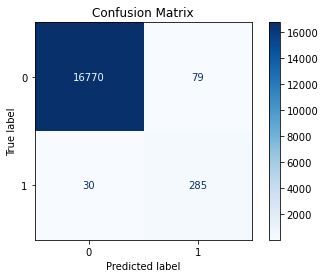

Submission file created: submission_file_ensemble.csv


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import Normalizer, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

# Load data
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

combined_df = pd.concat([train_df, test_df]).reset_index(drop=True)

### Step 1: Feature Engineering
# 1. Date Features
combined_df['disbursement_date'] = pd.to_datetime(combined_df['disbursement_date'])
combined_df['due_date'] = pd.to_datetime(combined_df['due_date'])
combined_df['loan_term_days'] = (combined_df['due_date'] - combined_df['disbursement_date']).dt.days

# 2. Financial Ratios
combined_df['repayment_ratio'] = combined_df['Total_Amount_to_Repay'] / combined_df['Total_Amount']
combined_df['lender_funded_ratio'] = combined_df['Amount_Funded_By_Lender'] / combined_df['Total_Amount']

# 3. One-hot encode categorical features
categorical_cols = ['country_id', 'loan_type', 'New_versus_Repeat']
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

# 4. Encode object IDs
id_cols = ['customer_id', 'tbl_loan_id', 'lender_id']
label_encoders = {col: LabelEncoder() for col in id_cols}
for col in id_cols:
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Split back into train and test
train = combined_df[combined_df['ID'].isin(train_df['ID'].unique())]
test = combined_df[combined_df['ID'].isin(test_df['ID'].unique())]

### Step 2: Define Features and Target
features = [col for col in train.columns if col not in ['ID', 'target', 'disbursement_date', 'due_date']]
X_test = test[features]

# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    train[features],
    train_df['target'],
    stratify=train_df['target'],
    shuffle=True,
    random_state=SEED
)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

### Step 3: Oversample Minority Class
smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

### Step 4: Feature Selection
selector = SelectKBest(score_func=mutual_info_classif, k=37)  # Select top 37 features
X_train_selected = selector.fit_transform(X_train_res, y_train_res)
X_valid_selected = selector.transform(X_valid)
X_test_selected = selector.transform(X_test)

selected_features = [features[i] for i in selector.get_support(indices=True)]
print("Selected Features:", selected_features)

### Step 5: Feature Normalization
normalizer = Normalizer()
X_train_normalized = normalizer.fit_transform(X_train_selected)
X_valid_normalized = normalizer.transform(X_valid_selected)
X_test_normalized = normalizer.transform(X_test_selected)

### Step 6: Train Logistic Regression for Minority Class
logreg = LogisticRegression(
    C=1,
    penalty='l2',
    solver='liblinear',
    class_weight='balanced',
    random_state=SEED,
    max_iter=500
)
logreg.fit(X_train_normalized, y_train_res)

# Predict probabilities for minority class
logreg_probs = logreg.predict(X_valid_normalized)#[:, 1]

### Step 7: Train XGBoost for Majority Class
xgb_model = xgb.XGBClassifier(
    colsample_bytree= 1,
    eta= 0.2,  # Learning rate
    eval_metric= 'auc',  # Evaluation metric
    max_depth = 10,  # Tree depth
    objective='binary:logistic',  # Binary classification
    scale_pos_weight= 1,  # Handle imbalance
    seed= SEED,  # Reproducibility
    subsample= 0.8  # Row sampling
)
xgb_model.fit(X_train_res, y_train_res)

# Predict probabilities for majority class
xgb_probs = xgb_model.predict(X_valid_selected)#[:, 1]

### Step 8: Combine Probabilities
w_logreg = 0.4  # Weight for Logistic Regression
w_xgb = 0.6     # Weight for XGBoost
combined_probs = w_logreg * logreg_probs + w_xgb * xgb_probs

# Final Predictions
final_preds = np.round(combined_probs > 0.5)#.astype(int)

### Step 9: Model Evaluation
print("\nClassification Report:\n", classification_report(y_valid, final_preds))
f1 = f1_score(y_valid, final_preds)
roc_auc = roc_auc_score(y_valid, combined_probs)
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

cm = confusion_matrix(y_valid, final_preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

### Step 10: Predict on Test Data
logreg_test_probs = logreg.predict(X_test_normalized)#[:, 1]
xgb_test_probs = xgb_model.predict(X_test_selected)#[:, 1]
test_combined_probs = w_logreg * logreg_test_probs + w_xgb * xgb_test_probs
test_preds = np.round(test_combined_probs > 0.5)#.astype(int)

test_df['target'] = test_preds

# Prepare submission file
submission = test_df[['ID', 'target']]
submission.to_csv("submission_file_ensemble.csv", index=False)
print("Submission file created: submission_file_ensemble.csv")


(51490, 37) (17164, 37) (51490,) (17164,)
Selected Features: ['customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount', 'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'loan_term_days', 'repayment_ratio', 'lender_funded_ratio', 'country_id_Kenya', 'loan_type_Type_10', 'loan_type_Type_11', 'loan_type_Type_12', 'loan_type_Type_13', 'loan_type_Type_14', 'loan_type_Type_15', 'loan_type_Type_16', 'loan_type_Type_17', 'loan_type_Type_18', 'loan_type_Type_19', 'loan_type_Type_2', 'loan_type_Type_20', 'loan_type_Type_21', 'loan_type_Type_22', 'loan_type_Type_23', 'loan_type_Type_24', 'loan_type_Type_3', 'loan_type_Type_4', 'loan_type_Type_5', 'loan_type_Type_6', 'loan_type_Type_7', 'loan_type_Type_8', 'loan_type_Type_9', 'New_versus_Repeat_Repeat Loan']

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16849
           1       0.77      0.91    

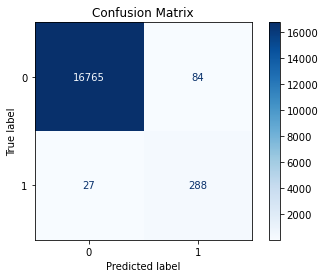

Submission file created: submission_file_ensemble.csv


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import Normalizer, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

# Load data
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

combined_df = pd.concat([train_df, test_df]).reset_index(drop=True)

### Step 1: Feature Engineering
# 1. Date Features
combined_df['disbursement_date'] = pd.to_datetime(combined_df['disbursement_date'])
combined_df['due_date'] = pd.to_datetime(combined_df['due_date'])
combined_df['loan_term_days'] = (combined_df['due_date'] - combined_df['disbursement_date']).dt.days

# 2. Financial Ratios
combined_df['repayment_ratio'] = combined_df['Total_Amount_to_Repay'] / combined_df['Total_Amount']
combined_df['lender_funded_ratio'] = combined_df['Amount_Funded_By_Lender'] / combined_df['Total_Amount']

# 3. One-hot encode categorical features
categorical_cols = ['country_id', 'loan_type', 'New_versus_Repeat']
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

# 4. Encode object IDs
id_cols = ['customer_id', 'tbl_loan_id', 'lender_id']
label_encoders = {col: LabelEncoder() for col in id_cols}
for col in id_cols:
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Split back into train and test
train = combined_df[combined_df['ID'].isin(train_df['ID'].unique())]
test = combined_df[combined_df['ID'].isin(test_df['ID'].unique())]

### Step 2: Define Features and Target
features = [col for col in train.columns if col not in ['ID', 'target', 'disbursement_date', 'due_date']]
X_test = test[features]

# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    train[features],
    train_df['target'],
    stratify=train_df['target'],
    shuffle=True,
    random_state=SEED
)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

### Step 3: Oversample Minority Class
smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

### Step 4: Feature Selection
selector = SelectKBest(score_func=mutual_info_classif, k=37)  # Select top 37 features
X_train_selected = selector.fit_transform(X_train_res, y_train_res)
X_valid_selected = selector.transform(X_valid)
X_test_selected = selector.transform(X_test)

selected_features = [features[i] for i in selector.get_support(indices=True)]
print("Selected Features:", selected_features)

# ### Step 5: Feature Normalization
# normalizer = Normalizer()
# X_train_normalized = normalizer.fit_transform(X_train_selected)
# X_valid_normalized = normalizer.transform(X_valid_selected)
# X_test_normalized = normalizer.transform(X_test_selected)

### Step 6: Train Logistic Regression for Minority Class
logreg = LogisticRegression(
    C=1,
    penalty='l2',
    solver='liblinear',
    class_weight='balanced',
    random_state=SEED,
    max_iter=500
)
logreg.fit(X_train_normalized, y_train_res)

# Predict probabilities for minority class
logreg_probs = logreg.predict(X_valid_normalized)#[:, 1]

### Step 7: Train XGBoost for Majority Class
xgb_model = xgb.XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.1,
    eval_metric='auc',
    max_depth=10,
    objective='binary:logistic',
    seed=SEED,
    subsample=0.8
)
xgb_model.fit(X_train_res, y_train_res)

# Predict probabilities for majority class
xgb_probs = xgb_model.predict(X_valid_selected)#[:, 1]

### Step 8: Combine Probabilities
w_logreg = 0.4  # Weight for Logistic Regression
w_xgb = 0.6     # Weight for XGBoost
combined_probs = w_logreg * logreg_probs + w_xgb * xgb_probs

# Final Predictions
final_preds = np.round(combined_probs > 0.5)#.astype(int)

### Step 9: Model Evaluation
print("\nClassification Report:\n", classification_report(y_valid, final_preds))
f1 = f1_score(y_valid, final_preds)
roc_auc = roc_auc_score(y_valid, combined_probs)
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

cm = confusion_matrix(y_valid, final_preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

### Step 10: Predict on Test Data
logreg_test_probs = logreg.predict(X_test_normalized)#[:, 1]
xgb_test_probs = xgb_model.predict(X_test_selected)#[:, 1]
test_combined_probs = w_logreg * logreg_test_probs + w_xgb * xgb_test_probs
test_preds = np.round(test_combined_probs > 0.5)#.astype(int)

test_df['target'] = test_preds

# Prepare submission file
submission = test_df[['ID', 'target']]
submission.to_csv("submission_file_ensemble.csv", index=False)
print("Submission file created: submission_file_ensemble.csv")


(51490, 37) (17164, 37) (51490,) (17164,)
Selected Features: ['customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount', 'Total_Amount_to_Repay', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'repayment_ratio', 'lender_funded_ratio']
[0]	train-auc:0.99700	valid-auc:0.98749
[100]	train-auc:1.00000	valid-auc:0.99644
[160]	train-auc:1.00000	valid-auc:0.99640

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     16849
           1       0.77      0.92      0.84       315

    accuracy                           0.99     17164
   macro avg       0.88      0.96      0.92     17164
weighted avg       0.99      0.99      0.99     17164

F1 Score: 0.8369
ROC AUC Score: 0.9942


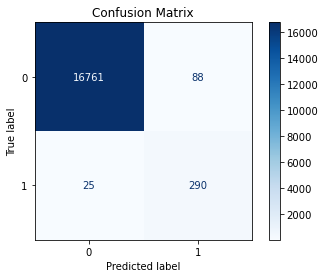

Submission file created: submission_file_combined.csv


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

# Load data
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

combined_df = pd.concat([train_df, test_df]).reset_index(drop=True)

### Step 1: Feature Engineering
# 1. Date Features
combined_df['disbursement_date'] = pd.to_datetime(combined_df['disbursement_date'])
combined_df['due_date'] = pd.to_datetime(combined_df['due_date'])
combined_df['loan_term_days'] = (combined_df['due_date'] - combined_df['disbursement_date']).dt.days

# 2. Financial Ratios
combined_df['repayment_ratio'] = combined_df['Total_Amount_to_Repay'] / combined_df['Total_Amount']
combined_df['lender_funded_ratio'] = combined_df['Amount_Funded_By_Lender'] / combined_df['Total_Amount']

# 3. One-hot encode categorical features
categorical_cols = ['country_id', 'loan_type', 'New_versus_Repeat']
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

# 4. Encode object IDs
id_cols = ['customer_id', 'tbl_loan_id', 'lender_id']
label_encoders = {col: LabelEncoder() for col in id_cols}
for col in id_cols:
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Split back into train and test
train = combined_df[combined_df['ID'].isin(train_df['ID'].unique())]
test = combined_df[combined_df['ID'].isin(test_df['ID'].unique())]

### Step 2: Define Features and Target
features = [col for col in train.columns if col not in ['ID', 'target', 'disbursement_date', 'due_date']]
X_test = test[features]

# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    train[features],
    train_df['target'],
    stratify=train_df['target'],
    shuffle=True,
    random_state=SEED
)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

### Step 3: Oversample Minority Class
smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

### Step 4: Feature Selection
selector = SelectKBest(score_func=mutual_info_classif, k=10)  # Select top 37 features
X_train_selected = selector.fit_transform(X_train_res, y_train_res)
X_valid_selected = selector.transform(X_valid)
X_test_selected = selector.transform(X_test)

selected_features = [features[i] for i in selector.get_support(indices=True)]
print("Selected Features:", selected_features)

### Step 5: Train Logistic Regression on Minority Class
logreg = LogisticRegression(
    C=1,
    penalty='l2',
    solver='liblinear',
    class_weight='balanced',
    random_state=SEED,
    max_iter=500
)
logreg.fit(X_train_selected, y_train_res)

# Predict probabilities with Logistic Regression
logreg_valid_probs = logreg.predict(X_valid_selected)#[:, 1]
logreg_test_probs = logreg.predict(X_test_selected)#[:, 1]

### Step 6: Train XGBoost on Majority Class with DMatrix
dtrain = xgb.DMatrix(X_train_res, label=y_train_res)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.1,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': SEED
}

evals = [(dtrain, 'train'), (dvalid, 'valid')]
xgb_model = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=50, evals=evals, verbose_eval=100)

# Predict probabilities with XGBoost
xgb_valid_probs = xgb_model.predict(dvalid)
xgb_test_probs = xgb_model.predict(dtest)

### Step 7: Combine Probabilities
w_logreg = 0.4  # Weight for Logistic Regression
w_xgb = 0.6     # Weight for XGBoost
combined_valid_probs = w_logreg * logreg_valid_probs + w_xgb * xgb_valid_probs
combined_test_probs = w_logreg * logreg_test_probs + w_xgb * xgb_test_probs

# Final Predictions
valid_preds = np.round(combined_valid_probs > 0.5)#.astype(int)
test_preds = np.round(combined_test_probs > 0.5)#.astype(int)

### Step 8: Model Evaluation
print("\nClassification Report:\n", classification_report(y_valid, valid_preds))
f1 = f1_score(y_valid, valid_preds)
roc_auc = roc_auc_score(y_valid, combined_valid_probs)
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

cm = confusion_matrix(y_valid, valid_preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

### Step 9: Prepare Submission
test_df['target'] = test_preds
submission = test_df[['ID', 'target']]
submission.to_csv("submission_file_combined.csv", index=False)
print("Submission file created: submission_file_combined.csv")


In [ ]:
# Logistic Regression for minority class
lr_model = LogisticRegression(class_weight='balanced', random_state=42)
lr_model.fit(X_train, y_train)
lr_probs = lr_model.predict_proba(X_valid)[:, 1]  # Probability for minority class (y=1)

# XGBoost for majority class
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    max_depth=5,
    eta=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED
)
xgb_model.fit(X_train, y_train)
xgb_probs = xgb_model.predict_proba(X_valid)[:, 1]  # Probability for minority class (y=1)

# Combine probabilities (adjust weights based on performance)
w_lr = 0.6
w_xgb = 0.4
final_probs = w_lr * lr_probs + w_xgb * xgb_probs

# Final predictions
final_preds = np.round(final_probs > 0.5)#.astype(int)

# Evaluate combined model
print("Classification Report:\n", classification_report(y_valid, final_preds))

#### Using XGBoost Classifier

In [48]:
features_for_modelling = ['Lender_portion_to_be_repaid',
                          'Amount_Funded_By_Lender',
                          'loan_type_Type_19',
                          'loan_type_Type_12',
                          'loan_type_Type_17',
                          'loan_type_Type_13',
                          'loan_type_Type_16',
                          'loan_type_Type_24',
                          'loan_type_Type_23',
                          'loan_type_Type_21',
                          'Total_Amount_to_Repay',
                          'loan_type_Type_15']

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_df[features_for_modelling], train['target'], stratify=train['target'], shuffle=True, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(51490, 40) (17164, 40) (51490,) (17164,)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 15.6min finished


[00:05:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best Parameters: {'colsample_bytree': 1, 'eta': 0.2, 'eval_metric': 'auc', 'max_depth': 7, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'seed': 42, 'subsample': 0.8}
F1 Score: 0.7175
ROC AUC Score: 0.9795

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     16849
           1       0.87      0.61      0.72       315

    accuracy                           0.99     17164
   macro avg       0.93      0.81      0.86     17164
weighted avg       0.99      0.99      0.99     17164



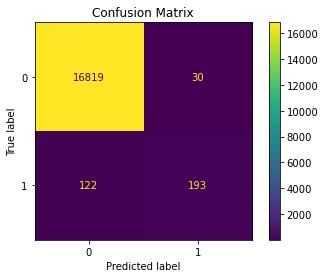

In [50]:
import xgboost as xgb
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Split the data into training and validation sets if not already done
# Assuming X and y are the full feature and label datasets
# X_train, X_valid, y_train, y_valid are assumed if pre-split
# Otherwise:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

# # XGBoost Data Matrix (DMatrix is a special format optimized for XGBoost)
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dvalid = xgb.DMatrix(X_valid, label=y_valid)

# Parameter grid for hyperparameter tuning
param_grid = {
    "eta": [0.01, 0.1, 0.2],  # Learning rate
    "max_depth": [3, 5, 7],   # Tree depth
    "scale_pos_weight": [1, len(y_train[y_train == 0]) / len(y_train[y_train == 1])],  # Handle imbalance
    "subsample": [0.8, 1],    # Row sampling
    "colsample_bytree": [0.8, 1],  # Feature sampling
    "objective": ["binary:logistic"],  # Binary classification
    "eval_metric": ["auc"],
    "seed": [SEED],
}

# XGBoost Model
xgb_clf = xgb.XGBClassifier(random_state=SEED)

# Cross-validation and Grid Search
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    verbose=1,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
best_xgb = grid_search.best_estimator_

# Predictions
y_pred = best_xgb.predict(X_valid)
y_pred_proba = best_xgb.predict_proba(X_valid)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_valid, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb.classes_).plot()
plt.title("Confusion Matrix")
plt.show()


### Using the best parameters obtained to train the XGBoost with all the features

In [ ]:
best_parameters = {'colsample_bytree': 1, 'eta': 0.2, 'eval_metric': 'auc', 'max_depth': 7, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'seed': 42, 'subsample': 0.8}

[0]	train-auc:0.79713	valid-auc:0.80815
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[10]	train-auc:0.89662	valid-auc:0.88585
[20]	train-auc:0.95709	valid-auc:0.93337
[30]	train-auc:0.98831	valid-auc:0.96831
[40]	train-auc:0.99497	valid-auc:0.97543
[50]	train-auc:0.99804	valid-auc:0.98048
[60]	train-auc:0.99899	valid-auc:0.98239
[70]	train-auc:0.99949	valid-auc:0.98362
[80]	train-auc:0.99979	valid-auc:0.98608
[90]	train-auc:0.99986	valid-auc:0.98665
[100]	train-auc:0.99993	valid-auc:0.98695
[110]	train-auc:0.99995	valid-auc:0.98727
[120]	train-auc:0.99996	valid-auc:0.98781
[130]	train-auc:0.99999	valid-auc:0.98791
[140]	train-auc:0.99999	valid-auc:0.98807
Stopping. Best iteration:
[123]	train-auc:0.99997	valid-auc:0.98820

F1 Score: 0.7332
ROC AUC Score: 0.9881

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     16

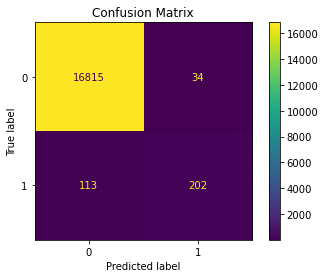

In [57]:
import xgboost as xgb
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Provided best parameters
best_params = {
    'colsample_bytree': 1,
    'eta': 0.2,  # Learning rate
    'eval_metric': 'auc',  # Evaluation metric
    'max_depth': 7,  # Tree depth
    'objective': 'binary:logistic',  # Binary classification
    'scale_pos_weight': 1,  # Handle imbalance
    'seed': SEED,  # Reproducibility
    'subsample': 0.8  # Row sampling
}

# Train the model
xgb_model = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=500,  # Max boosting rounds
    early_stopping_rounds=20,  # Stop if no improvement
    verbose_eval=10  # Progress updates every 10 rounds
)

# Predictions on validation data
y_pred_proba = xgb_model.predict(dvalid)
y_pred = (y_pred_proba >= 0.5).astype(int)  # Convert probabilities to binary

# Evaluation Metrics
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_valid, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot()
plt.title("Confusion Matrix")
plt.show()


F1 Score: 0.7063
ROC AUC Score: 0.9868

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     16849
           1       0.85      0.60      0.71       315

    accuracy                           0.99     17164
   macro avg       0.92      0.80      0.85     17164
weighted avg       0.99      0.99      0.99     17164



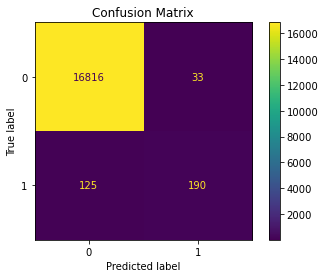

In [62]:
import xgboost as xgb
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Split the data into training and validation sets if not already done
# Assuming X and y are the full feature and label datasets
# X_train, X_valid, y_train, y_valid are assumed if pre-split
# Otherwise:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

# Set best parameters
best_params = {
    'colsample_bytree': 1,
    'eta': 0.2,  # Learning rate
    'eval_metric': 'auc',  # Evaluation metric
    'max_depth': 7,  # Tree depth
    'objective': 'binary:logistic',  # Binary classification
    'scale_pos_weight': 1,  # Handle imbalance
    'seed': SEED,  # Reproducibility
    'subsample': 0.8  # Row sampling
}

# XGBoost Model
xgb_clf = xgb.XGBClassifier(**best_params)

# Train the model
xgb_clf.fit(X_train, y_train)

# Predictions
y_pred = xgb_clf.predict(X_valid)
y_pred_proba = xgb_clf.predict_proba(X_valid)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_valid, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_).plot()
plt.title("Confusion Matrix")
plt.show()


#### Run the XGBoost Classifier without performing any encoding

In [83]:
data = pd.concat([train, test]).reset_index(drop=True)

In [84]:
# Convert the datetime columns appropriately
date_cols = ['disbursement_date', 'due_date']
for col in date_cols:
    data[col] = pd.to_datetime(data[col])
    # Extract month, day, and year from the date columns
    data[col+'_month'] = data[col].dt.month
    data[col+'_day'] = data[col].dt.day
    data[col+'_year'] = data[col].dt.year

In [85]:
# Select all categorical columns from the dataset and label encode them or one hot encode
cat_cols = data.select_dtypes(include='object').columns
num_cols = [col for col in data.select_dtypes(include='number').columns if col not in ['target']]
print(f"The categorical columns are: {cat_cols}.")
print("-"* 100)
print(f"The numerical columns are: {num_cols}")
print("-"* 100)
# we are going to one  hot encode the loan type
# data = pd.get_dummies(data, columns=['loan_type'], prefix='loan_type', drop_first=False)
# Convert all the columns with prefix loan_type_ to 0/1 instead of False/True
loan_type_cols = [col for col in data.columns if col.startswith('loan_type_')]
data[loan_type_cols] = data[loan_type_cols].astype(int)

# Label-encoding for the other remaining categorical columns
le = LabelEncoder()
for col in [col for col in cat_cols if col not in ['ID']]:
    data[col] = le.fit_transform(data[col])

The categorical columns are: Index(['ID', 'country_id', 'loan_type', 'New_versus_Repeat'], dtype='object').
----------------------------------------------------------------------------------------------------
The numerical columns are: ['customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount', 'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'disbursement_date_month', 'disbursement_date_day', 'disbursement_date_year', 'due_date_month', 'due_date_day', 'due_date_year']
----------------------------------------------------------------------------------------------------


In [86]:
# Splitting the data back into train and test
train_df = data[data['ID'].isin(train['ID'].unique())]

test_df = data[data['ID'].isin(test['ID'].unique())]

In [87]:
# we are also going to drop the country id as we saw we have only one country in train
features_for_modelling = [col for col in train_df.columns if col not in date_cols + ['ID', 'target', 'country_id']]

In [88]:
features_for_modelling

['customer_id',
 'tbl_loan_id',
 'lender_id',
 'loan_type',
 'Total_Amount',
 'Total_Amount_to_Repay',
 'duration',
 'New_versus_Repeat',
 'Amount_Funded_By_Lender',
 'Lender_portion_Funded',
 'Lender_portion_to_be_repaid',
 'disbursement_date_month',
 'disbursement_date_day',
 'disbursement_date_year',
 'due_date_month',
 'due_date_day',
 'due_date_year']

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_df[features_for_modelling], train['target'], stratify=train['target'], shuffle=True, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(51490, 17) (17164, 17) (51490,) (17164,)


F1 Score: 0.7105
ROC AUC Score: 0.9874

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     16849
           1       0.87      0.60      0.71       315

    accuracy                           0.99     17164
   macro avg       0.93      0.80      0.85     17164
weighted avg       0.99      0.99      0.99     17164



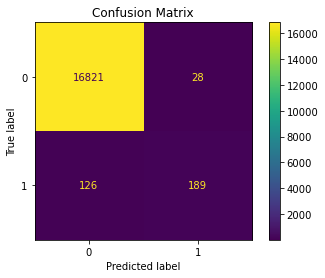

In [75]:

# Set best parameters
best_params = {
    'colsample_bytree': 1,
    'eta': 0.2,  # Learning rate
    'eval_metric': 'auc',  # Evaluation metric
    'max_depth': 7,  # Tree depth
    'objective': 'binary:logistic',  # Binary classification
    'scale_pos_weight': 1,  # Handle imbalance
    'seed': SEED,  # Reproducibility
    'subsample': 0.8  # Row sampling
}

# XGBoost Model
xgb_clf = xgb.XGBClassifier(**best_params)

# Train the model
xgb_clf.fit(X_train, y_train)

# Predictions
y_pred = xgb_clf.predict(X_valid)
y_pred_proba = xgb_clf.predict_proba(X_valid)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_valid, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_).plot()
plt.title("Confusion Matrix")
plt.show()


[0]	validation_0-auc:0.80288
Will train until validation_0-auc hasn't improved in 20 rounds.
[10]	validation_0-auc:0.90338
[20]	validation_0-auc:0.93334
[30]	validation_0-auc:0.96892
[40]	validation_0-auc:0.97676
[50]	validation_0-auc:0.98155
[60]	validation_0-auc:0.98198
[70]	validation_0-auc:0.98395
[80]	validation_0-auc:0.98566
[90]	validation_0-auc:0.98648
[99]	validation_0-auc:0.98740
F1 Score: 0.7094
ROC AUC Score: 0.9877

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     16849
           1       0.87      0.60      0.71       315

    accuracy                           0.99     17164
   macro avg       0.93      0.80      0.85     17164
weighted avg       0.99      0.99      0.99     17164



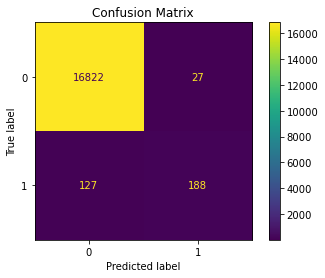

In [80]:
import xgboost as xgb
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Best Parameters from previous tuning
best_params = {
    'colsample_bytree': 1,
    'eta': 0.2,  # Learning rate
    'eval_metric': 'auc',  # Evaluation metric
    'max_depth': 7,  # Tree depth
    'objective': 'binary:logistic',  # Binary classification
    'scale_pos_weight': 1,  # Handle imbalance
    'seed': SEED,  # Reproducibility
    'subsample': 0.8  # Row sampling
}

# XGBoost Classifier
xgb_clf = xgb.XGBClassifier(**best_params)

# Fit the model
xgb_clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=20, verbose=10)

# Predictions on the validation set
y_pred = xgb_clf.predict(X_valid)
y_pred_proba = xgb_clf.predict_proba(X_valid)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_valid, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_).plot()
plt.title("Confusion Matrix")
plt.show()


#### Using Normalized data

[0]	validation_0-auc:0.77234
Will train until validation_0-auc hasn't improved in 20 rounds.
[10]	validation_0-auc:0.89194
[20]	validation_0-auc:0.95089
[30]	validation_0-auc:0.96682
[40]	validation_0-auc:0.97208
[50]	validation_0-auc:0.97573
[60]	validation_0-auc:0.97883
[70]	validation_0-auc:0.98194
[80]	validation_0-auc:0.98223
[90]	validation_0-auc:0.98340
[99]	validation_0-auc:0.98368
F1 Score: 0.6523
ROC AUC Score: 0.9837

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     16849
           1       0.86      0.53      0.65       315

    accuracy                           0.99     17164
   macro avg       0.92      0.76      0.82     17164
weighted avg       0.99      0.99      0.99     17164



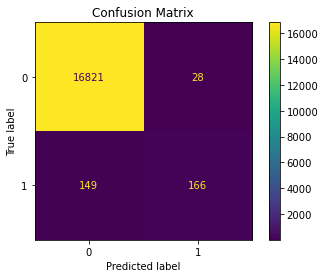

In [94]:
import xgboost as xgb
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)


# Normalize the data
normalizer = Normalizer()
X_train_normalized = normalizer.fit_transform(X_train)
X_valid_normalized = normalizer.transform(X_valid)

# Best Parameters from previous tuning
best_params = {
    'colsample_bytree': 1,
    'eta': 0.2,  # Learning rate
    'eval_metric': 'auc',  # Evaluation metric
    'max_depth': 7,  # Tree depth
    'objective': 'binary:logistic',  # Binary classification
    'scale_pos_weight': 1,  # Handle imbalance
    'seed': SEED,  # Reproducibility
    'subsample': 0.8  # Row sampling
}

# XGBoost Classifier
xgb_clf = xgb.XGBClassifier(**best_params)

# Fit the model with normalized data
xgb_clf.fit(X_train_normalized, y_train, eval_set=[(X_valid_normalized, y_valid)], early_stopping_rounds=20, verbose=10)

# Predictions on the validation set
y_pred = xgb_clf.predict(X_valid_normalized)
y_pred_proba = xgb_clf.predict_proba(X_valid_normalized)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_valid, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_).plot()
plt.title("Confusion Matrix")
plt.show()


In [35]:
# # Make predictions on the test dataset
# test_predictions = xgb_clf.predict(test_df[features_for_modelling])
# test_predictions_proba = xgb_clf.predict_proba(test_df[features_for_modelling])[:, 1]

In [97]:
# Save the predictions to a CSV file
test_df['target'] = test_predictions
sub = test_df[['ID', 'target']]
sub.to_csv('submission.csv', index=False)
sub.head()

,ID,target
68654,ID_269404226088267278,0
68655,ID_255356300042267278,0
68656,ID_257026243764267278,0
68657,ID_264617299409267278,0
68658,ID_247613296713267278,0


In [36]:
# # Make predictions on the test dataset
# test_predictions = xgb_clf.predict(test_df[features_for_modelling])
# test_predictions_proba = xgb_clf.predict_proba(test_df[features_for_modelling])[:, 1]

# # Save the predictions to a CSV file

# test_df['target'] = test_predictions
# sub =  test_df[['ID', 'target']]
# sub.head()


In [98]:
sub.to_csv('baseline_submission.csv', index=False)

#### To Do
* Handle imbalance
* Do more feature engineering
* Use more sophisticated machine learning algorithms
##### Good luck

In [100]:
data_fed = pd.read_csv('economic_indicators.csv')
data_fed.head()

,Country,Indicator,YR2001,YR2002,YR2003,YR2004,YR2005,YR2006,YR2007,YR2008,...,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021,YR2022,YR2023
0,Ghana,"Inflation, consumer prices (annual %)",41.509496,9.360932,29.772980,18.042739,15.438992,11.679184,10.734267,16.494640,...,15.489616,17.149970,17.454635,12.371922,7.808765,7.143640,9.887290,9.971089,31.255895,38.106966
1,Cote d'Ivoire,"Inflation, consumer prices (annual %)",4.361529,3.077265,3.296807,1.457988,3.885830,2.467191,1.892006,6.308528,...,0.448682,1.251500,0.723178,0.685881,0.359409,-1.106863,2.425007,4.091952,5.276167,4.387117
2,Kenya,"Inflation, consumer prices (annual %)",5.738598,1.961308,9.815691,11.624036,10.312778,14.453734,9.758880,26.239817,...,6.878155,6.582154,6.297250,8.005650,4.689806,5.239638,5.405162,6.107936,7.659863,7.671396
3,Ghana,"Official exchange rate (LCU per US$, period av...",0.716305,0.792417,0.866764,0.899495,0.905209,0.915107,0.932619,1.052275,...,2.896575,3.714642,3.909817,4.350533,4.585325,5.217367,5.595708,5.805700,8.272400,11.020408
4,Cote d'Ivoire,"Official exchange rate (LCU per US$, period av...",732.397693,693.713226,579.897426,527.338032,527.258363,522.425625,478.633718,446.000041,...,493.757330,591.211698,592.605615,580.656750,555.446458,585.911013,575.586005,554.530675,623.759701,606.569750


In [101]:
data_fed.columns

Index(['Country', 'Indicator', 'YR2001', 'YR2002', 'YR2003', 'YR2004',
       'YR2005', 'YR2006', 'YR2007', 'YR2008', 'YR2009', 'YR2010', 'YR2011',
       'YR2012', 'YR2013', 'YR2014', 'YR2015', 'YR2016', 'YR2017', 'YR2018',
       'YR2019', 'YR2020', 'YR2021', 'YR2022', 'YR2023'],
      dtype='object')

train['target].value_counts()

In [10]:
import pandas as pd
pd.set_option('display.max_colwidth', None) # No truncation of column content
variables = pd.read_csv('VariableDefinitions.txt', sep='\n')
variables

,## Description of variables in Train/Test.csv
0,0. **ID**: A unique identifier for each entry in the dataset.
1,1. **customer_id**: Unique identifier for each customer in the dataset.
2,2. **country_id**: Identifier or code representing the country where the customer resides or where the loan was issued.
3,3. **tbl_loan_id**: Unique identifier for each loan associated with the customer.
4,4. **Total_Amount**: The total loan amount initially disbursed to the customer.
5,"5. **Total_Amount_to_Repay**: The total amount the customer is expected to repay, including principal, interest, and fees."
6,6. **loan_type**: The category or type of loan.
7,7. **disbursement_date**: The date when the loan amount was disbursed to the customer.
8,"8. **duration**: The length of the loan term, typically expressed in days"
9,9. **lender_id**: Unique identifier for the lender or institution that issued the loan.


(51490, 37) (17164, 37) (51490,) (17164,)
[0]	validation_0-auc:0.98343	validation_1-auc:0.97349
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[10]	validation_0-auc:0.99437	validation_1-auc:0.98799
[20]	validation_0-auc:0.99474	validation_1-auc:0.98812
[30]	validation_0-auc:0.99482	validation_1-auc:0.98991
[40]	validation_0-auc:0.99767	validation_1-auc:0.99232
[50]	validation_0-auc:0.99774	validation_1-auc:0.99257
[60]	validation_0-auc:0.99911	validation_1-auc:0.99508
[70]	validation_0-auc:0.99938	validation_1-auc:0.99584
[80]	validation_0-auc:0.99954	validation_1-auc:0.99650
[90]	validation_0-auc:0.99962	validation_1-auc:0.99696
[100]	validation_0-auc:0.99969	validation_1-auc:0.99723
[110]	validation_0-auc:0.99974	validation_1-auc:0.99729
[120]	validation_0-auc:0.99978	validation_1-auc:0.99730
[130]	validation_0-auc:0.99983	validation_1-auc:0.99729
[140]	validation_0-auc:0.999

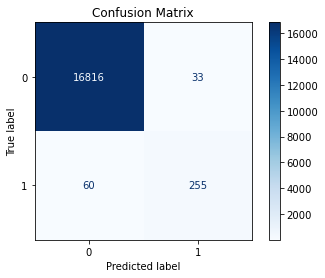

Submission file created: submission_file.csv


In [22]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    f1_score,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

# Load data
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

combined_df = pd.concat([train_df, test_df]).reset_index(drop=True)

# Feature Engineering
# 1. Date Features
combined_df['disbursement_date'] = pd.to_datetime(combined_df['disbursement_date'])
combined_df['due_date'] = pd.to_datetime(combined_df['due_date'])
combined_df['loan_term_days'] = (combined_df['due_date'] - combined_df['disbursement_date']).dt.days

# 2. Financial Ratios
combined_df['repayment_ratio'] = combined_df['Total_Amount_to_Repay'] / combined_df['Total_Amount']
combined_df['lender_funded_ratio'] = combined_df['Amount_Funded_By_Lender'] / combined_df['Total_Amount']

# 3. One-hot encode categorical features
categorical_cols = ['country_id', 'loan_type', 'New_versus_Repeat']
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

# 4. Encode object IDs (e.g., customer_id, tbl_loan_id, lender_id)
id_cols = ['customer_id', 'tbl_loan_id', 'lender_id']
label_encoders = {col: LabelEncoder() for col in id_cols}
for col in id_cols:
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Splitting the data back into train and test
train = combined_df[combined_df['ID'].isin(train_df['ID'].unique())]
test = combined_df[combined_df['ID'].isin(test_df['ID'].unique())]                                                         
                                                         
# Define features and target
# we are also going to drop the country id as we saw we have only one country in train
# features_for_modelling = [col for col in train_df.columns if col not in date_cols + ['ID', 'target', 'country_id']]                                                         
                                                         
features = [col for col in train.columns if col not in ['ID', 'target', 'disbursement_date', 'due_date']]
# X = train[features]
# y = train['target']
# X_test = test_df[features]

# # Train/validation split
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train[features], train_df['target'], stratify=train_df['target'], shuffle=True, random_state=SEED)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

# XGBoost Classifier
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 500,
    'random_state': SEED
}
xgb_clf = xgb.XGBClassifier(**xgb_params)
xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    early_stopping_rounds=20,
    verbose=10
)

# Feature Importance from XGBoost
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_clf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Select top 11 features
top_features = feature_importance.head(11)['feature'].tolist()
print("Top 11 Features:\n", top_features)

# Filter data with top features
X_train_selected = X_train[top_features]
X_valid_selected = X_valid[top_features]
X_test_selected = X_test[top_features]

# Retrain model with selected features
xgb_clf.fit(
    X_train_selected, y_train,
    eval_set=[(X_train_selected, y_train), (X_valid_selected, y_valid)],
    early_stopping_rounds=20,
    verbose=10
)

# Validation predictions
y_valid_pred = xgb_clf.predict(X_valid_selected)
y_valid_pred_proba = xgb_clf.predict_proba(X_valid_selected)[:, 1]

# Metrics and Evaluation
f1 = f1_score(y_valid, y_valid_pred)
roc_auc = roc_auc_score(y_valid, y_valid_pred_proba)

print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_valid, y_valid_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Predict probabilities for the test dataset
test_df['target'] = xgb_clf.predict_proba(X_test_selected)[:, 1]

# Prepare submission file
submission = test_df[['ID', 'target']]
submission.to_csv("submission_file.csv", index=False)
print("Submission file created: submission_file.csv")



Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16849
           1       0.89      0.81      0.85       315

    accuracy                           0.99     17164
   macro avg       0.94      0.90      0.92     17164
weighted avg       0.99      0.99      0.99     17164

F1 Score: 0.8458
ROC AUC Score: 0.9952


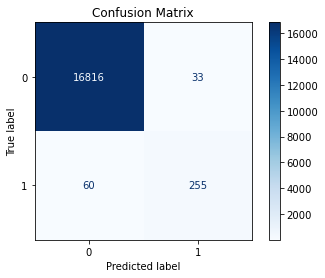

Submission file created: submission_file.csv


In [69]:
# Validation predictions using predict
y_valid_pred = xgb_clf.predict(X_valid_selected)

# Metrics and Evaluation
f1 = f1_score(y_valid, y_valid_pred)
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))
print(f"F1 Score: {f1:.4f}")

roc_auc = roc_auc_score(y_valid, y_valid_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_valid, y_valid_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Predict hard classes for the test dataset
test_df['target'] = xgb_clf.predict(X_test_selected)

# Prepare submission file
submission = test_df[['ID', 'target']]
submission.to_csv("submission_file.csv", index=False)
print("Submission file created: submission_file.csv")


**Notes:**

The above resulted to position 119 with score 0.67 on the Leaderboard

In [12]:
!pip install xgboost

In [14]:
pip install -U xgboost


(51490, 37) (17164, 37) (51490,) (17164,)
[0]	train-auc:0.98725	eval-auc:0.97948
[10]	train-auc:0.99525	eval-auc:0.99064
[20]	train-auc:0.99621	eval-auc:0.99182
[30]	train-auc:0.99816	eval-auc:0.99228
[40]	train-auc:0.99901	eval-auc:0.99346
[50]	train-auc:0.99952	eval-auc:0.99374
[60]	train-auc:0.99968	eval-auc:0.99436
[70]	train-auc:0.99977	eval-auc:0.99560
[80]	train-auc:0.99984	eval-auc:0.99646
[90]	train-auc:0.99989	eval-auc:0.99655
[100]	train-auc:0.99992	eval-auc:0.99677
[110]	train-auc:0.99994	eval-auc:0.99683
[120]	train-auc:0.99996	eval-auc:0.99666
[130]	train-auc:0.99998	eval-auc:0.99654
[140]	train-auc:0.99998	eval-auc:0.99649
[150]	train-auc:0.99999	eval-auc:0.99643
[157]	train-auc:0.99999	eval-auc:0.99642

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16849
           1       0.86      0.83      0.85       315

    accuracy                           0.99     17164
   macro avg       0.93      

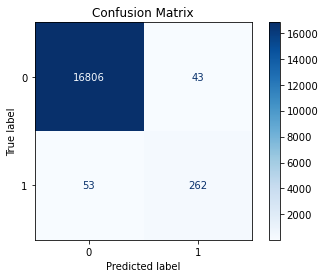

Submission file created: submission_file.csv


In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    f1_score,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

# Load data
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

combined_df = pd.concat([train_df, test_df]).reset_index(drop=True)

# Feature Engineering
# 1. Date Features
combined_df['disbursement_date'] = pd.to_datetime(combined_df['disbursement_date'])
combined_df['due_date'] = pd.to_datetime(combined_df['due_date'])
combined_df['loan_term_days'] = (combined_df['due_date'] - combined_df['disbursement_date']).dt.days

# 2. Financial Ratios
combined_df['repayment_ratio'] = combined_df['Total_Amount_to_Repay'] / combined_df['Total_Amount']
combined_df['lender_funded_ratio'] = combined_df['Amount_Funded_By_Lender'] / combined_df['Total_Amount']

# 3. One-hot encode categorical features
categorical_cols = ['country_id', 'loan_type', 'New_versus_Repeat']
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

# 4. Encode object IDs (e.g., customer_id, tbl_loan_id, lender_id)
id_cols = ['customer_id', 'tbl_loan_id', 'lender_id']
label_encoders = {col: LabelEncoder() for col in id_cols}
for col in id_cols:
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Splitting the data back into train and test
train = combined_df[combined_df['ID'].isin(train_df['ID'].unique())]
test = combined_df[combined_df['ID'].isin(test_df['ID'].unique())]

# Define features and target
features = [col for col in train.columns if col not in ['ID', 'target', 'disbursement_date', 'due_date']]
X_test = test[features]

# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    train[features],
    train_df['target'],
    stratify=train_df['target'],
    shuffle=True,
    random_state=SEED
)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

# Use DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

# Train the XGBoost model
xgb_clf = xgb.train(
    params={
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'colsample_bytree': 0.8,
        'subsample': 0.8,
        'learning_rate': 0.1,
        'max_depth': 10,
        'seed': SEED
    },
    dtrain=dtrain,
    num_boost_round=500,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=10
)

# Predict and evaluate on validation set
y_valid_pred = np.round(xgb_clf.predict(dvalid))# > 0.5).astype(int)

# Metrics and Evaluation
f1 = f1_score(y_valid, y_valid_pred)
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))
print(f"F1 Score: {f1:.4f}")

roc_auc = roc_auc_score(y_valid, y_valid_pred)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_valid, y_valid_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Prepare test data for predictions
dtest = xgb.DMatrix(X_test)
test_df['target'] = np.round(xgb_clf.predict(dtest))# > 0.5).astype(int)

# Prepare submission file
submission = test_df[['ID', 'target']]
submission.to_csv("submission_file.csv", index=False)
print("Submission file created: submission_file.csv")

**Notes:**

The results for the above code got me to number 7 on the leaderboard with a score of 0.724035608

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    f1_score,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

# Load data
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

combined_df = pd.concat([train_df, test_df]).reset_index(drop=True)

# Feature Engineering
combined_df['disbursement_date'] = pd.to_datetime(combined_df['disbursement_date'])
combined_df['due_date'] = pd.to_datetime(combined_df['due_date'])
combined_df['loan_term_days'] = (combined_df['due_date'] - combined_df['disbursement_date']).dt.days
combined_df['repayment_ratio'] = combined_df['Total_Amount_to_Repay'] / combined_df['Total_Amount']
combined_df['lender_funded_ratio'] = combined_df['Amount_Funded_By_Lender'] / combined_df['Total_Amount']

# One-hot encode categorical features
categorical_cols = ['country_id', 'loan_type', 'New_versus_Repeat']
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

# Encode object IDs
id_cols = ['customer_id', 'tbl_loan_id', 'lender_id']
label_encoders = {col: LabelEncoder() for col in id_cols}
for col in id_cols:
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Splitting the data back into train and test
train = combined_df[combined_df['ID'].isin(train_df['ID'].unique())]
test = combined_df[combined_df['ID'].isin(test_df['ID'].unique())]

# Define features and target
features = [col for col in train.columns if col not in ['ID', 'target', 'disbursement_date', 'due_date']]
X_test = test[features]

X_train, X_valid, y_train, y_valid = train_test_split(
    train[features],
    train_df['target'],
    stratify=train_df['target'],
    shuffle=True,
    random_state=SEED
)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

# Define XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, random_state=SEED)

# Hyperparameter tuning
param_grid = {
#     "eta": [0.01, 0.1, 0.2],  # Learning rate
#     "max_depth": [3, 5, 7],   # Tree depth
    "scale_pos_weight": [1, len(y_train[y_train == 0]) / len(y_train[y_train == 1])],  # Handle imbalance
#     "subsample": [0.8, 1],    # Row sampling
#     "colsample_bytree": [0.8, 1],  # Feature sampling
    "gamma": [0, 0.1, 0.5, 1],  # Minimum loss reduction
    "min_child_weight": [1, 5, 10],  # Minimum child weight
    "lambda": [0, 1, 5],  # L2 regularization
    "alpha": [0, 1, 5],  # L1 regularization
#     "n_estimators": [100, 200, 300],  # Boosting rounds
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate on validation set
best_model = grid_search.best_estimator_
y_valid_pred = np.round(best_model.predict(X_valid))

# Metrics and Evaluation
f1 = f1_score(y_valid, y_valid_pred)
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))
print(f"F1 Score: {f1:.4f}")

roc_auc = roc_auc_score(y_valid, y_valid_pred)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_valid, y_valid_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Predict on test data
test_df['target'] = np.round(best_model.predict(X_test))

# Prepare submission file
submission = test_df[['ID', 'target']]
submission.to_csv("submission_file.csv", index=False)
print("Submission file created: submission_file.csv")


In [1]:
!pip install xgboost


In [3]:
!pip install category_encoders


     -------------------------------------- 82.0/82.0 kB 381.7 kB/s eta 0:00:00


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
import xgboost as xgb
from category_encoders import TargetEncoder

# Set random seed for reproducibility
SEED = 42

# Load the datasets (replace with actual file paths or data)
train_df = pd.read_csv("train.csv")  # Ensure train.csv exists
test_df = pd.read_csv("test.csv")    # Ensure test.csv exists

# Add a placeholder for target in test data
test_df['target'] = np.nan

# Combine train and test datasets for consistent encoding
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Define categorical columns for target encoding
categorical_cols = ['country_id', 'loan_type', 'New_versus_Repeat']

# Separate train rows with non-null targets for encoding
train_mask = combined_df['target'].notnull()

# Apply TargetEncoder only on train data
target_encoder = TargetEncoder(cols=categorical_cols)
combined_df.loc[train_mask, categorical_cols] = target_encoder.fit_transform(
    combined_df.loc[train_mask, categorical_cols],
    combined_df.loc[train_mask, 'target']
)

# Apply transform to test data using the fitted encoder
combined_df.loc[~train_mask, categorical_cols] = target_encoder.transform(
    combined_df.loc[~train_mask, categorical_cols]
)

# Ensure all encoded columns are numeric
for col in categorical_cols:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

# Split the data back into train and test
train = combined_df[train_mask].copy()
test = combined_df[~train_mask].copy()

# Drop unnecessary columns
features = [col for col in train.columns if col not in ['ID', 'target', 'disbursement_date', 'due_date', 'dataset']]
X_train_full = train[features]
y_train_full = train['target']
X_test = test[features]

# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full,
    y_train_full,
    stratify=y_train_full,
    shuffle=True,
    random_state=SEED
)

# Ensure all feature data types are numeric
X_train = X_train.astype(float)
X_valid = X_valid.astype(float)
X_test = X_test.astype(float)

# Convert datasets into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test)

# Define parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'learning_rate': 0.1,
    'max_depth': 10,
    'seed': SEED
}

# Train XGBoost model
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_clf = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=10
)

# Validate model performance
y_valid_pred = xgb_clf.predict(dvalid)
auc_score = roc_auc_score(y_valid, y_valid_pred)
print(f"Validation AUC Score: {auc_score:.4f}")

# Convert predictions to binary for confusion matrix and F1 score
y_valid_pred_binary = (y_valid_pred >= 0.5).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_valid, y_valid_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Compute F1 score
f1 = f1_score(y_valid, y_valid_pred_binary)
print(f"F1 Score: {f1:.4f}")

# Make predictions on test data
test_df['target'] = xgb_clf.predict(dtest)

# Save submission file
submission = test_df[['ID', 'target']]
submission.to_csv("submission_file.csv", index=False)
print("Submission file created: submission_file.csv")


[0]	train-auc:0.85189	eval-auc:0.83657
[10]	train-auc:0.97088	eval-auc:0.94096
[20]	train-auc:0.98336	eval-auc:0.95544
[30]	train-auc:0.99095	eval-auc:0.96767
[40]	train-auc:0.99587	eval-auc:0.97346
[50]	train-auc:0.99727	eval-auc:0.97573
[60]	train-auc:0.99796	eval-auc:0.97862
[70]	train-auc:0.99836	eval-auc:0.98040
[80]	train-auc:0.99890	eval-auc:0.98241
[90]	train-auc:0.99927	eval-auc:0.98468
[100]	train-auc:0.99948	eval-auc:0.98521
[110]	train-auc:0.99963	eval-auc:0.98640
[120]	train-auc:0.99971	eval-auc:0.98661
[130]	train-auc:0.99981	eval-auc:0.98682
[140]	train-auc:0.99985	eval-auc:0.98704
[150]	train-auc:0.99988	eval-auc:0.98733
[160]	train-auc:0.99992	eval-auc:0.98731
[170]	train-auc:0.99993	eval-auc:0.98769
[180]	train-auc:0.99995	eval-auc:0.98805
[190]	train-auc:0.99996	eval-auc:0.98834
[200]	train-auc:0.99997	eval-auc:0.98838
[210]	train-auc:0.99998	eval-auc:0.98819
[220]	train-auc:0.99998	eval-auc:0.98800
[230]	train-auc:0.99999	eval-auc:0.98787
[240]	train-auc:0.99999	eva

Adding feature selection on the below code


Classification Report (KNN):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     16849
           1       0.92      0.65      0.76       315

    accuracy                           0.99     17164
   macro avg       0.96      0.82      0.88     17164
weighted avg       0.99      0.99      0.99     17164

F1 Score (KNN): 0.7598
ROC AUC Score (KNN): 0.8233


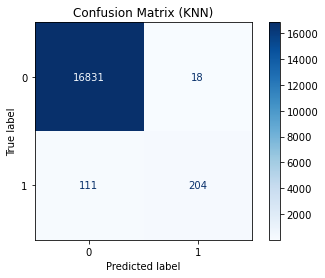

KNN Submission file created: submission_file_knn.csv


In [68]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Normalize the features for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Train KNN classifier
knn_clf = KNeighborsClassifier(n_neighbors=2)  # 5 is a common choice for KNN, you can tune this parameter.
knn_clf.fit(X_train_scaled, y_train)

# Predict and evaluate on validation set
y_valid_pred_knn = knn_clf.predict(X_valid_scaled)

# Metrics and Evaluation for KNN
f1_knn = f1_score(y_valid, y_valid_pred_knn)
print("\nClassification Report (KNN):\n", classification_report(y_valid, y_valid_pred_knn))
print(f"F1 Score (KNN): {f1_knn:.4f}")

roc_auc_knn = roc_auc_score(y_valid, y_valid_pred_knn)
print(f"ROC AUC Score (KNN): {roc_auc_knn:.4f}")

# Confusion Matrix for KNN
cm_knn = confusion_matrix(y_valid, y_valid_pred_knn)
ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix (KNN)")
plt.show()

# Prepare test data for predictions
X_test_scaled_knn = scaler.transform(X_test)
test_df['target_knn'] = knn_clf.predict(X_test_scaled_knn)

# Prepare submission file
submission_knn = test_df[['ID', 'target_knn']]
submission_knn.to_csv("submission_file_knn.csv", index=False)
print("KNN Submission file created: submission_file_knn.csv")


In [70]:
!pip install imbalanced-learn


     ------------------------------------ 258.3/258.3 kB 792.6 kB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

# Load data
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

combined_df = pd.concat([train_df, test_df]).reset_index(drop=True)

# Feature Engineering (same as before)
combined_df['disbursement_date'] = pd.to_datetime(combined_df['disbursement_date'])
combined_df['due_date'] = pd.to_datetime(combined_df['due_date'])
combined_df['loan_term_days'] = (combined_df['due_date'] - combined_df['disbursement_date']).dt.days
combined_df['repayment_ratio'] = combined_df['Total_Amount_to_Repay'] / combined_df['Total_Amount']
combined_df['lender_funded_ratio'] = combined_df['Amount_Funded_By_Lender'] / combined_df['Total_Amount']

categorical_cols = ['country_id', 'loan_type', 'New_versus_Repeat']
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

id_cols = ['customer_id', 'tbl_loan_id', 'lender_id']
label_encoders = {col: LabelEncoder() for col in id_cols}
for col in id_cols:
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Split back into train and test
train = combined_df[combined_df['ID'].isin(train_df['ID'].unique())]
test = combined_df[combined_df['ID'].isin(test_df['ID'].unique())]

# Define features and target
features = [col for col in train.columns if col not in ['ID', 'target', 'disbursement_date', 'due_date']]
X_test = test[features]

# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    train[features],
    train_df['target'],
    stratify=train_df['target'],
    shuffle=True,
    random_state=SEED
)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

# Apply SMOTE for handling class imbalance
smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Train SVM classifier
svm_clf = SVC(kernel='rbf', C=1.0, class_weight='balanced', random_state=SEED, probability=True)

svm_clf.fit(X_train_scaled, y_train_res)

# Predictions
y_valid_pred = svm_clf.predict(X_valid_scaled)

# Metrics
f1 = f1_score(y_valid, y_valid_pred)
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))
print(f"F1 Score: {f1:.4f}")

roc_auc = roc_auc_score(y_valid, svm_clf.predict_proba(X_valid_scaled)[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_valid, y_valid_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Prepare test data for predictions
X_test_preds = svm_clf.predict(X_test_scaled)

# Prepare submission file
test_df['target'] = X_test_preds
submission = test_df[['ID', 'target']]
submission.to_csv("submission_file_svm.csv", index=False)
print("Submission file created: submission_file_svm.csv")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

# Load data
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

combined_df = pd.concat([train_df, test_df]).reset_index(drop=True)

# Feature Engineering (same as before)
combined_df['disbursement_date'] = pd.to_datetime(combined_df['disbursement_date'])
combined_df['due_date'] = pd.to_datetime(combined_df['due_date'])
combined_df['loan_term_days'] = (combined_df['due_date'] - combined_df['disbursement_date']).dt.days
combined_df['repayment_ratio'] = combined_df['Total_Amount_to_Repay'] / combined_df['Total_Amount']
combined_df['lender_funded_ratio'] = combined_df['Amount_Funded_By_Lender'] / combined_df['Total_Amount']

categorical_cols = ['country_id', 'loan_type', 'New_versus_Repeat']
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

id_cols = ['customer_id', 'tbl_loan_id', 'lender_id']
label_encoders = {col: LabelEncoder() for col in id_cols}
for col in id_cols:
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Split back into train and test
train = combined_df[combined_df['ID'].isin(train_df['ID'].unique())]
test = combined_df[combined_df['ID'].isin(test_df['ID'].unique())]

# Define features and target
features = [col for col in train.columns if col not in ['ID', 'target', 'disbursement_date', 'due_date']]
X_test = test[features]

# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    train[features],
    train_df['target'],
    stratify=train_df['target'],
    shuffle=True,
    random_state=SEED
)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

# Apply SMOTE for class imbalance
smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Train LightGBM classifier
lgbm_clf = LGBMClassifier(
    objective='binary',
    metric='auc',
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.05,
    n_estimators=100,
    class_weight='balanced',
    random_state=SEED,
    verbose=-1
)

lgbm_clf.fit(X_train_scaled, y_train_res, eval_set=[(X_valid_scaled, y_valid)], 
             eval_metric='auc', early_stopping_rounds=50, verbose=10)

# Predictions
y_valid_pred = lgbm_clf.predict(X_valid_scaled)

# Metrics
f1 = f1_score(y_valid, y_valid_pred)
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))
print(f"F1 Score: {f1:.4f}")

roc_auc = roc_auc_score(y_valid, lgbm_clf.predict_proba(X_valid_scaled)[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_valid, y_valid_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Prepare test data for predictions
X_test_preds = lgbm_clf.predict(X_test_scaled)

# Prepare submission file
test_df['target'] = X_test_preds
submission = test_df[['ID', 'target']]
submission.to_csv("submission_file_lgbm.csv", index=False)
print("Submission file created: submission_file_lgbm.csv")


(51490, 37) (17164, 37) (51490,) (17164,)
[0]	validation_0-auc:0.98664	validation_1-auc:0.97931
[10]	validation_0-auc:0.99480	validation_1-auc:0.99181
[20]	validation_0-auc:0.99561	validation_1-auc:0.99215
[30]	validation_0-auc:0.99697	validation_1-auc:0.99268
[40]	validation_0-auc:0.99847	validation_1-auc:0.99386
[50]	validation_0-auc:0.99871	validation_1-auc:0.99395
[60]	validation_0-auc:0.99919	validation_1-auc:0.99442
[70]	validation_0-auc:0.99933	validation_1-auc:0.99553
[80]	validation_0-auc:0.99945	validation_1-auc:0.99645
[90]	validation_0-auc:0.99951	validation_1-auc:0.99651
[100]	validation_0-auc:0.99960	validation_1-auc:0.99661
[110]	validation_0-auc:0.99970	validation_1-auc:0.99672
[120]	validation_0-auc:0.99974	validation_1-auc:0.99678
[130]	validation_0-auc:0.99980	validation_1-auc:0.99682
[140]	validation_0-auc:0.99984	validation_1-auc:0.99677
[150]	validation_0-auc:0.99987	validation_1-auc:0.99676
[160]	validation_0-auc:0.99990	validation_1-auc:0.99675
[170]	validation_

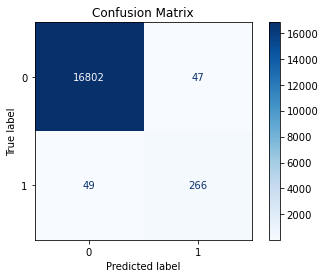

Submission file created: submission_file.csv


In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    f1_score,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

# Load data
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

combined_df = pd.concat([train_df, test_df]).reset_index(drop=True)

# Feature Engineering
# 1. Date Features
combined_df['disbursement_date'] = pd.to_datetime(combined_df['disbursement_date'])
combined_df['due_date'] = pd.to_datetime(combined_df['due_date'])
combined_df['loan_term_days'] = (combined_df['due_date'] - combined_df['disbursement_date']).dt.days

# 2. Financial Ratios
combined_df['repayment_ratio'] = combined_df['Total_Amount_to_Repay'] / combined_df['Total_Amount']
combined_df['lender_funded_ratio'] = combined_df['Amount_Funded_By_Lender'] / combined_df['Total_Amount']

# 3. One-hot encode categorical features
categorical_cols = ['country_id', 'loan_type', 'New_versus_Repeat']
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

# 4. Encode object IDs (e.g., customer_id, tbl_loan_id, lender_id)
id_cols = ['customer_id', 'tbl_loan_id', 'lender_id']
label_encoders = {col: LabelEncoder() for col in id_cols}
for col in id_cols:
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Splitting the data back into train and test
train = combined_df[combined_df['ID'].isin(train_df['ID'].unique())]
test = combined_df[combined_df['ID'].isin(test_df['ID'].unique())]                                                         
                                                         
# Define features and target
# we are also going to drop the country id as we saw we have only one country in train
# features_for_modelling = [col for col in train_df.columns if col not in date_cols + ['ID', 'target', 'country_id']]                                                         
                                                         
features = [col for col in train.columns if col not in ['ID', 'target', 'disbursement_date', 'due_date']]
# X = train[features]
# y = train['target']
X_test = test[features]

# # Train/validation split
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train[features], train_df['target'], stratify=train_df['target'], shuffle=True, random_state=SEED)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

# XGBoost Classifier
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 500,
    'random_state': SEED
}
xgb_clf = xgb.XGBClassifier(**xgb_params)
xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
#     early_stopping_rounds=20,
    verbose=10
)

# Feature Importance from XGBoost
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_clf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Select top 11 features
top_features = feature_importance.head(19)['feature'].tolist()
print("Top 19 Features:\n", top_features)

# Filter data with top features
X_train_selected = X_train[top_features]
X_valid_selected = X_valid[top_features]
X_test_selected = X_test[top_features]

# Retrain model with selected features
xgb_clf.fit(
    X_train_selected, y_train,
    eval_set=[(X_train_selected, y_train), (X_valid_selected, y_valid)],
#     early_stopping_rounds=20,
    verbose=10
)

# Validation predictions using predict
y_valid_pred = xgb_clf.predict(X_valid_selected)

# Metrics and Evaluation
f1 = f1_score(y_valid, y_valid_pred)
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))
print(f"F1 Score: {f1:.4f}")

roc_auc = roc_auc_score(y_valid, y_valid_pred)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_valid, y_valid_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Predict hard classes for the test dataset
test_df['target'] = xgb_clf.predict(X_test_selected)

# Prepare submission file
submission = test_df[['ID', 'target']]
submission.to_csv("submission_file.csv", index=False)
print("Submission file created: submission_file.csv")


**Notes:**
With the use of 12 features on the above code, I got a score of 0.703488372 on the leader board.

With the use of 13 features on the above code, I got a score of 0.699708454 on the leader board.

With the use of 17 features on the above code, I got a score of 0.708708708 on the leader board.

With the use of 19 features on the above code, I got a score of 0.715542521 on the leader board.

With the use of 23 features on the above code, I got a score of 0.707246376 on the leader board.

With the use of 30 features on the above code, I got a score of 0.713450292 on the leader board.






**To submit file 9 which was trained with 19 features**



In [73]:
len(test.columns)

41

#### Training on Random Forest Classifier

Top 15 Features:
 ['repayment_ratio', 'Lender_portion_to_be_repaid', 'tbl_loan_id', 'Amount_Funded_By_Lender', 'Total_Amount_to_Repay', 'Total_Amount', 'customer_id', 'Lender_portion_Funded', 'lender_funded_ratio', 'duration', 'loan_term_days', 'lender_id', 'loan_type_Type_14', 'loan_type_Type_4', 'loan_type_Type_2']

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16849
           1       0.88      0.83      0.86       315

    accuracy                           0.99     17164
   macro avg       0.94      0.92      0.93     17164
weighted avg       0.99      0.99      0.99     17164

F1 Score: 0.8553
ROC AUC Score: 0.9871


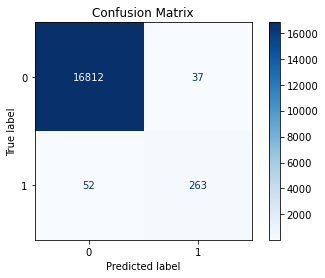

Submission file created: submission_file.csv


In [94]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    f1_score,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

# Load data
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

# Combine train and test data for consistent preprocessing
combined_df = pd.concat([train_df, test_df]).reset_index(drop=True)

# Feature Engineering
# 1. Date Features
combined_df['disbursement_date'] = pd.to_datetime(combined_df['disbursement_date'])
combined_df['due_date'] = pd.to_datetime(combined_df['due_date'])
combined_df['loan_term_days'] = (combined_df['due_date'] - combined_df['disbursement_date']).dt.days

# 2. Financial Ratios
combined_df['repayment_ratio'] = combined_df['Total_Amount_to_Repay'] / combined_df['Total_Amount']
combined_df['lender_funded_ratio'] = combined_df['Amount_Funded_By_Lender'] / combined_df['Total_Amount']

# 3. One-hot encode categorical features
categorical_cols = ['country_id', 'loan_type', 'New_versus_Repeat']
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

# 4. Encode object IDs (e.g., customer_id, tbl_loan_id, lender_id)
id_cols = ['customer_id', 'tbl_loan_id', 'lender_id']
label_encoders = {col: LabelEncoder() for col in id_cols}
for col in id_cols:
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Splitting the data back into train and test
train = combined_df[combined_df['ID'].isin(train_df['ID'].unique())]
test = combined_df[combined_df['ID'].isin(test_df['ID'].unique())]

# Define features and target
features = [col for col in train.columns if col not in ['ID', 'target', 'disbursement_date', 'due_date']]

# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(train[features], train_df['target'], stratify=train_df['target'], random_state=SEED, shuffle=True)

# Random Forest Classifier
rf_params = {
    'n_estimators': 100,  # Number of trees
    'max_depth': None,     # No max depth limit
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': SEED,
    'n_jobs': -1            # Use all available CPU cores
}
rf_clf = RandomForestClassifier(**rf_params)
rf_clf.fit(X_train, y_train)

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_clf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Select top 15 features based on importance
top_features = feature_importance.head(15)['feature'].tolist()
print("Top 15 Features:\n", top_features)

# Filter data with top features
X_train_selected = X_train[top_features]
X_valid_selected = X_valid[top_features]
X_test_selected = test[top_features]

# Retrain model with selected features
rf_clf.fit(X_train_selected, y_train)

# Validation predictions
y_valid_pred = rf_clf.predict(X_valid_selected)

# Metrics and Evaluation
f1 = f1_score(y_valid, y_valid_pred)
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))
print(f"F1 Score: {f1:.4f}")

roc_auc = roc_auc_score(y_valid, rf_clf.predict_proba(X_valid_selected)[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_valid, y_valid_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Predict probabilities for the test dataset
test_df['target'] = rf_clf.predict(X_test_selected)

# Prepare submission file
submission = test_df[['ID', 'target']]
submission.to_csv("submission_file_ra.csv", index=False)
print("Submission file created: submission_file.csv")


In [1]:
!pip install catboost


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    f1_score,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import LabelEncoder
import catboost as cb
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

# Load data
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

# Combine train and test data for consistent preprocessing
combined_df = pd.concat([train_df, test_df]).reset_index(drop=True)

# Feature Engineering
# 1. Date Features
combined_df['disbursement_date'] = pd.to_datetime(combined_df['disbursement_date'])
combined_df['due_date'] = pd.to_datetime(combined_df['due_date'])
combined_df['loan_term_days'] = (combined_df['due_date'] - combined_df['disbursement_date']).dt.days

# 2. Financial Ratios
combined_df['repayment_ratio'] = combined_df['Total_Amount_to_Repay'] / combined_df['Total_Amount']
combined_df['lender_funded_ratio'] = combined_df['Amount_Funded_By_Lender'] / combined_df['Total_Amount']

# Handle missing values (fill with -1 for numeric, "unknown" for categorical)
combined_df.fillna(
    {col: -1 for col in combined_df.select_dtypes(include=[np.number]).columns}, inplace=True
)
combined_df.fillna(
    {col: "unknown" for col in combined_df.select_dtypes(include=[object]).columns}, inplace=True
)

# Encode categorical features manually
categorical_cols = ['country_id', 'loan_type', 'New_versus_Repeat']

label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Encode object IDs (e.g., customer_id, tbl_loan_id, lender_id)
id_cols = ['customer_id', 'tbl_loan_id', 'lender_id']
label_encoders.update({col: LabelEncoder() for col in id_cols})
for col in id_cols:
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Splitting the data back into train and test
train = combined_df[combined_df['ID'].isin(train_df['ID'].unique())]
test = combined_df[combined_df['ID'].isin(test_df['ID'].unique())]

# Define features and target
features = [col for col in train.columns if col not in ['ID', 'target', 'disbursement_date', 'due_date']]
target = 'target'

# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    train[features],
    train_df[target],
    stratify=train_df[target],
    random_state=SEED,
    shuffle=True,
)

# Hyperparameter Tuning
grid_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [6, 8, 10],
    'iterations': [500, 1000],
    'l2_leaf_reg': [3, 5, 7],
    'border_count': [32, 64],
}

catboost_clf = cb.CatBoostClassifier(
    eval_metric='AUC',
    random_seed=SEED,
    cat_features=categorical_cols,
    verbose=0
)

grid_search = GridSearchCV(
    estimator=catboost_clf,
    param_grid=grid_params,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best Parameters and Model
print("\nBest Parameters:", grid_search.best_params_)
catboost_clf = grid_search.best_estimator_

# Retrain Model with Selected Features
catboost_clf.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50)

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': catboost_clf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Select top 10 features based on importance
top_features = feature_importance.head(10)['feature'].tolist()
print("Top 10 Features:\n", top_features)

# Filter data with top features
X_train_selected = X_train[top_features]
X_valid_selected = X_valid[top_features]
X_test_selected = test[top_features]

# Retrain model with selected features
catboost_clf.fit(X_train_selected, y_train)

# Validation predictions
y_valid_pred = catboost_clf.predict(X_valid_selected)

# Metrics and Evaluation
f1 = f1_score(y_valid, y_valid_pred)
roc_auc = roc_auc_score(y_valid, catboost_clf.predict_proba(X_valid_selected)[:, 1])

print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_valid, y_valid_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Predict classes for the test dataset
test_df['target'] = catboost_clf.predict(X_test_selected)

# Prepare submission file
submission = test_df[['ID', 'target']]
submission.to_csv("submission_file_zindi.csv", index=False)
print("Submission file created: submission_file_zindi.csv")


Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best Parameters: {'border_count': 64, 'depth': 6, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
Top 10 Features:
 ['repayment_ratio', 'tbl_loan_id', 'customer_id', 'lender_funded_ratio', 'Lender_portion_to_be_repaid', 'Total_Amount_to_Repay', 'Lender_portion_Funded', 'Amount_Funded_By_Lender', 'Total_Amount', 'duration']


ValueError: 'country_id' is not in list

Best Parameters: {'border_count': 64, 'depth': 6, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.1}

In [98]:
print("Features:", X_train.columns.tolist())


Features: ['customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount', 'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'loan_term_days', 'repayment_ratio', 'lender_funded_ratio', 'country_id_Kenya', 'loan_type_Type_10', 'loan_type_Type_11', 'loan_type_Type_12', 'loan_type_Type_13', 'loan_type_Type_14', 'loan_type_Type_15', 'loan_type_Type_16', 'loan_type_Type_17', 'loan_type_Type_18', 'loan_type_Type_19', 'loan_type_Type_2', 'loan_type_Type_20', 'loan_type_Type_21', 'loan_type_Type_22', 'loan_type_Type_23', 'loan_type_Type_24', 'loan_type_Type_3', 'loan_type_Type_4', 'loan_type_Type_5', 'loan_type_Type_6', 'loan_type_Type_7', 'loan_type_Type_8', 'loan_type_Type_9', 'New_versus_Repeat_Repeat Loan']


0:	test: 0.9745786	best: 0.9745786 (0)	total: 100ms	remaining: 59.9s
10:	test: 0.9878308	best: 0.9882008 (8)	total: 1.01s	remaining: 53.9s
20:	test: 0.9905539	best: 0.9905539 (20)	total: 1.88s	remaining: 51.9s
30:	test: 0.9910351	best: 0.9910351 (30)	total: 2.77s	remaining: 50.8s
40:	test: 0.9911445	best: 0.9911445 (40)	total: 3.62s	remaining: 49.4s
50:	test: 0.9922176	best: 0.9922278 (49)	total: 4.52s	remaining: 48.6s
60:	test: 0.9922532	best: 0.9923114 (57)	total: 5.37s	remaining: 47.5s
70:	test: 0.9924491	best: 0.9924491 (70)	total: 6.22s	remaining: 46.3s
80:	test: 0.9925143	best: 0.9925415 (79)	total: 7.09s	remaining: 45.4s
90:	test: 0.9926637	best: 0.9927353 (84)	total: 7.97s	remaining: 44.6s
100:	test: 0.9926902	best: 0.9927353 (84)	total: 8.85s	remaining: 43.7s
110:	test: 0.9927738	best: 0.9927808 (108)	total: 9.73s	remaining: 42.9s
120:	test: 0.9928111	best: 0.9928111 (120)	total: 10.6s	remaining: 41.9s
130:	test: 0.9928549	best: 0.9928597 (121)	total: 11.5s	remaining: 41s
140:

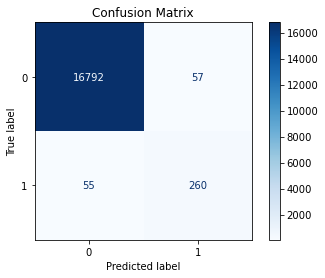

Submission file created: submission_file_ca.csv


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    f1_score,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import LabelEncoder
import catboost as cb
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

# Load data
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

# Combine train and test data for consistent preprocessing
combined_df = pd.concat([train_df, test_df]).reset_index(drop=True)

# Feature Engineering
# 1. Date Features
combined_df['disbursement_date'] = pd.to_datetime(combined_df['disbursement_date'])
combined_df['due_date'] = pd.to_datetime(combined_df['due_date'])
combined_df['loan_term_days'] = (combined_df['due_date'] - combined_df['disbursement_date']).dt.days

# 2. Financial Ratios
combined_df['repayment_ratio'] = combined_df['Total_Amount_to_Repay'] / combined_df['Total_Amount']
combined_df['lender_funded_ratio'] = combined_df['Amount_Funded_By_Lender'] / combined_df['Total_Amount']

# Encode categorical features manually
categorical_cols = ['country_id', 'loan_type', 'New_versus_Repeat']

label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Encode object IDs (e.g., customer_id, tbl_loan_id, lender_id)
id_cols = ['customer_id', 'tbl_loan_id', 'lender_id']
label_encoders.update({col: LabelEncoder() for col in id_cols})
for col in id_cols:
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Splitting the data back into train and test
train = combined_df[combined_df['ID'].isin(train_df['ID'].unique())]
test = combined_df[combined_df['ID'].isin(test_df['ID'].unique())]

# Define features and target
features = [col for col in train.columns if col not in ['ID', 'target', 'disbursement_date', 'due_date']]

# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    train[features], train_df['target'], stratify=train_df['target'], random_state=SEED, shuffle=True
)

# CatBoost Model Parameters
catboost_params = {
    'objective': 'Logloss',  # binary log loss for classification
    'eval_metric': 'AUC',    # use AUC for performance monitoring
    'learning_rate': 0.1,   # learning rate
    'depth': 6,              # tree depth
    'iterations': 600,      # number of trees
    'od_wait': 50,           # early stopping if no improvement after 50 rounds
    'random_seed': SEED,
    'cat_features': categorical_cols,  # specify categorical features
    'verbose': 10,
    'l2_leaf_reg': 5,
    'colsample_bylevel': 0.8,
    'border_count': 64
}
# Best Parameters: {'border_count': 64, 'depth': 6, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
# Train the CatBoost model
catboost_clf = cb.CatBoostClassifier(**catboost_params)

# Fit the model using only selected features
catboost_clf.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50)

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': catboost_clf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Select top 15 features based on importance
top_features = feature_importance.head(30)['feature'].tolist()
print("Top 30 Features:\n", top_features)

# Filter data with top features
X_train_selected = X_train[top_features]
X_valid_selected = X_valid[top_features]
X_test_selected = test[top_features]

# Retrain model with selected features
catboost_clf.fit(X_train_selected, y_train)

# Validation predictions
y_valid_pred = catboost_clf.predict(X_valid_selected)

# Metrics and Evaluation
f1 = f1_score(y_valid, y_valid_pred)
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))
print(f"F1 Score: {f1:.4f}")

roc_auc = roc_auc_score(y_valid, y_valid_pred)  # Using predicted labels
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_valid, y_valid_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Test predictions using `.predict`
test_df['target'] = catboost_clf.predict(X_test_selected)

# Prepare submission file
submission = test_df[['ID', 'target']]
submission.to_csv("submission_file_ca.csv", index=False)
print("Submission file created: submission_file_ca.csv")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import LabelEncoder
import catboost as cb
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

SEED = 42
np.random.seed(SEED)

# Load data
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

# Combine train and test data for consistent preprocessing
combined_df = pd.concat([train_df, test_df]).reset_index(drop=True)

# Feature Engineering
# 1. Date Features
combined_df['disbursement_date'] = pd.to_datetime(combined_df['disbursement_date'])
combined_df['due_date'] = pd.to_datetime(combined_df['due_date'])
combined_df['loan_term_days'] = (combined_df['due_date'] - combined_df['disbursement_date']).dt.days

# 2. Financial Ratios
combined_df['repayment_ratio'] = combined_df['Total_Amount_to_Repay'] / combined_df['Total_Amount']
combined_df['lender_funded_ratio'] = combined_df['Amount_Funded_By_Lender'] / combined_df['Total_Amount']

# Encode categorical features manually
categorical_cols = ['country_id', 'loan_type', 'New_versus_Repeat']

label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Encode object IDs (e.g., customer_id, tbl_loan_id, lender_id)
id_cols = ['customer_id', 'tbl_loan_id', 'lender_id']
for col in id_cols:
    label_encoders[col] = LabelEncoder()
    combined_df[col] = label_encoders[col].fit_transform(combined_df[col])

# Splitting the data back into train and test
train = combined_df[combined_df['ID'].isin(train_df['ID'].unique())]
test = combined_df[combined_df['ID'].isin(test_df['ID'].unique())]

# Define features and target
features = [col for col in train.columns if col not in ['ID', 'target', 'disbursement_date', 'due_date']]
target = 'target'

# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    train[features], train_df[target], stratify=train_df[target], random_state=SEED, shuffle=True
)

# Stratified K-Fold Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# CatBoost Model and Hyperparameter Tuning
catboost_params = {
    'objective': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': SEED,
    'cat_features': categorical_cols,
    'verbose': False,
}

catboost_clf = cb.CatBoostClassifier(**catboost_params)

grid_params = {
    'depth': [6, 8, 10],
    'iterations': [500, 700, 1000],
    'learning_rate': [0.03, 0.05, 0.1],
    'l2_leaf_reg': [3, 5, 7],
}

grid_search = GridSearchCV(
    estimator=catboost_clf,
    param_grid=grid_params,
    cv=skf,
    scoring='roc_auc',
    verbose=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Fit best model
best_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50)

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Select top 20 features based on importance
top_features = feature_importance.head(20)['feature'].tolist()
print("Top 20 Features:\n", top_features)

# Filter data with top features
X_train_selected = X_train[top_features]
X_valid_selected = X_valid[top_features]
X_test_selected = test[top_features]

# Retrain model with selected features
best_model.fit(X_train_selected, y_train, eval_set=(X_valid_selected, y_valid), early_stopping_rounds=50)

# Predictions
y_valid_pred = best_model.predict(X_valid_selected)
y_valid_proba = best_model.predict_proba(X_valid_selected)[:, 1]

# Metrics and Evaluation
f1 = f1_score(y_valid, y_valid_pred)
roc_auc = roc_auc_score(y_valid, y_valid_proba)

print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_valid, y_valid_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Test predictions
test_df['target'] = best_model.predict(X_test_selected)

# Prepare submission file
submission = test_df[['ID', 'target']]
submission.to_csv("submission_file_optimized.csv", index=False)
print("Submission file created: submission_file_optimized.csv")
